# Recovering gold from ore
We need to prepare a prototype machine learning model for "Digitala". The company develops solutions for efficient operation for industrial enterprises.
The model should predict the recovery rate of gold from gold-containing ore. Data with mining and purification parameters are available. 
The model will help to optimize production, so that the company does not run the plant with unprofitable characteristics.
Steps:  
1. Prepare the data;  
2. Conduct exploratory analysis of the data;  
3. Build and train the model.  

**Process Description:**  
1. **Flotation.** A mixture of gold-bearing ore is fed into a flotation plant. After beneficiation, a rough concentrate and "tailings", i.e. product residue with low concentration of valuable metals, are obtained.  
The stability of this process is affected by the unstable and suboptimal physical and chemical state of the flotation slurry (a mixture of solids and liquid).  
2. **Purification.** The rough concentrate undergoes two purifications. The output is a final concentrate and new tailings.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats as st
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Additional package for visualizing model training, used in additional item (3.3.3)
# If you don't want to put it on your computer, please comment out item 3.3.3
# so that the whole notebook will be compiled
!pip install shap
import shap

import warnings
warnings.filterwarnings('ignore')

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Data-study" data-toc-modified-id="Data-study-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data study</a></span></li><li><span><a href="#Principle-of-dividing-a-common-dataset" data-toc-modified-id="Principle-of-dividing-a-common-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Principle of dividing a common dataset</a></span></li><li><span><a href="#Verify-enrichment-efficiency-calculation" data-toc-modified-id="Verify-enrichment-efficiency-calculation-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Verify enrichment efficiency calculation</a></span></li><li><span><a href="#Missing-values-in-test-dataset" data-toc-modified-id="Missing-values-in-test-dataset-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Missing values in test dataset</a></span><ul class="toc-item"><li><span><a href="#Data-preprocessing" data-toc-modified-id="Data-preprocessing-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Data preprocessing</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Metal-Concentration-(Au,-Ag,-Pb)" data-toc-modified-id="Metal-Concentration-(Au,-Ag,-Pb)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Metal Concentration (Au, Ag, Pb)</a></span><ul class="toc-item"><li><span><a href="#Silver-concentration" data-toc-modified-id="Silver-concentration-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Silver concentration</a></span></li><li><span><a href="#Lead-concentration" data-toc-modified-id="Lead-concentration-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Lead concentration</a></span></li><li><span><a href="#Gold-concentration" data-toc-modified-id="Gold-concentration-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Gold concentration</a></span></li></ul></li><li><span><a href="#Pellet-size-distribution" data-toc-modified-id="Pellet-size-distribution-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pellet size distribution</a></span></li><li><span><a href="#Total-Metal-Concentration" data-toc-modified-id="Total-Metal-Concentration-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Total Metal Concentration</a></span></li><li><span><a href="#Temporal-changes?" data-toc-modified-id="Temporal-changes?-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Temporal changes?</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Function-to-calculate-the-total-sMAPE" data-toc-modified-id="Function-to-calculate-the-total-sMAPE-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Function to calculate the total sMAPE</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model Training</a></span><ul class="toc-item"><li><span><a href="#Preparing-and-splitting-samples" data-toc-modified-id="Preparing-and-splitting-samples-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Preparing and splitting samples</a></span></li><li><span><a href="#Functions-for-model-training" data-toc-modified-id="Functions-for-model-training-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Functions for model training</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-3.2.2.1"><span class="toc-item-num">3.2.2.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Decision-tree" data-toc-modified-id="Decision-tree-3.2.2.2"><span class="toc-item-num">3.2.2.2&nbsp;&nbsp;</span>Decision tree</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-3.2.2.3"><span class="toc-item-num">3.2.2.3&nbsp;&nbsp;</span>Random forest</a></span></li></ul></li><li><span><a href="#Models-Training" data-toc-modified-id="Models-Training-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Models Training</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></li><li><span><a href="#Best-model-and-its-validation-on-a-test-sample" data-toc-modified-id="Best-model-and-its-validation-on-a-test-sample-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Best model and its validation on a test sample</a></span><ul class="toc-item"><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Model Comparison</a></span></li><li><span><a href="#Test-sample" data-toc-modified-id="Test-sample-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Test sample</a></span></li><li><span><a href="#Parametrs-input-analysis" data-toc-modified-id="Parametrs-input-analysis-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Parametrs input analysis</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Dummy-model" data-toc-modified-id="Dummy-model-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Dummy model</a></span></li></ul></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span><ul class="toc-item"><li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Data preparation</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Data Analysis</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Training the model</a></span></li></ul></li></ul></div>

## Data Preparation   
The following steps should be performed:
1. Open the data and examine them.
2. Check that the enrichment efficiency is calculated correctly. Calculate it on the training sample for the trait rougher.output.recovery. Find the MAE between your calculation and the trait value. Describe your findings.
3. Analyze the features that are not available in the test sample. What are these parameters? What type do they belong to?
4. Pre-process the data.

### Data study

In [2]:
# Downloading data
try:
    data_train = pd.read_csv('/datasets/gold_industry_train.csv')
    data_test = pd.read_csv('/datasets/gold_industry_test.csv')
    data_full = pd.read_csv('/datasets/gold_industry_full.csv')
except:
    data_train = pd.read_csv(r'C:\Users\Ivan\datasetsYP\gold_industry_train.csv')
    data_test = pd.read_csv(r'C:\Users\Ivan\datasetsYP\gold_industry_test.csv')
    data_full = pd.read_csv(r'C:\Users\Ivan\datasetsYP\gold_industry_full.csv')    
     
# Function for analyzing datasets, since there are three of them, it is easier to write a function
def dataset_information(df, name):
    print(f'Information about {name} datset \n\n\n')
    df.shape
    df.info()
   
    print('Duplicates:', df.duplicated().sum())
    print('Missing values: \n', df.isna().sum())
    print('Column names:', df.columns)

    display(df.sample(20))
    
    return

# Infor about datsets
dataset_information(data_train, 'data_train')
dataset_information(data_test, 'data_test')
dataset_information(data_full, 'data_full')

Information about data_train datset 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate  

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
10742,2017-06-20 10:59:59,8.706555,10.086836,2.744892,42.220795,651.126142,87.185532,14.062190,7.698907,1196.871244,...,5.302170,45.593619,6.006184,8.908479,9.010542,76.440687,2.401798,10.190082,2.000152,12.883418
3272,2016-06-25 22:59:59,10.447039,10.994488,4.102150,36.652135,417.499613,56.412989,14.003079,6.196249,1002.519425,...,10.829999,45.091870,5.216324,9.645849,8.613026,70.376021,3.697744,11.261531,3.100432,10.952397
7142,2016-12-24 18:59:59,7.681457,8.404430,3.766765,38.490145,409.798570,51.120251,12.500089,5.101217,1300.097431,...,0.000000,45.382870,4.925694,11.270914,11.625030,63.092337,3.173996,9.420430,3.280859,12.377613
1986,2016-04-29 18:59:59,6.748134,7.194294,3.069140,29.743761,436.865023,47.707110,11.998028,5.997536,1000.277241,...,7.980177,43.547140,4.886882,10.588086,8.115359,59.640960,3.000819,7.448375,2.240381,11.288235
1542,2016-03-25 23:00:00,9.978825,10.102879,2.823998,36.192310,500.339460,60.695068,11.987044,5.299378,1004.444656,...,11.558209,44.453552,5.869647,9.290184,11.305158,69.458293,3.610674,10.947641,1.935882,11.991823
556,2016-02-09 16:00:00,6.605557,8.436374,2.683558,35.761333,501.183629,55.098838,9.528157,6.883802,999.864601,...,11.877599,40.846000,6.318033,11.416637,7.419323,66.428597,2.484479,11.303791,1.398532,12.131552
4286,2016-08-14 19:59:59,11.200737,11.701144,3.932756,37.232416,449.488209,46.068022,15.005771,7.298033,999.566814,...,11.570937,46.982901,5.181712,8.686975,11.766524,68.783592,4.182279,12.228551,3.061592,10.872078
11747,2017-08-03 21:59:59,8.825931,9.277313,2.986252,44.375773,458.491124,73.066396,9.166331,6.501463,1399.981898,...,2.191438,46.987767,4.984032,9.416272,9.153314,70.457562,3.005101,9.245601,1.604223,13.939092
11680,2017-08-01 00:59:59,9.562866,11.881438,4.108822,39.337163,541.011581,57.724985,10.182307,7.605365,1400.476488,...,5.698317,43.918843,5.936612,10.670171,8.453029,72.261445,3.147896,13.705037,3.160505,11.072377
12346,2017-08-30 04:59:59,6.838802,8.838165,3.192459,40.151246,572.413140,77.090739,9.024488,6.796719,1405.592054,...,0.394365,45.735993,5.342915,10.138681,7.581815,74.326225,1.975311,10.067279,1.863985,9.861119


Information about data_test datset 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             48

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
365,2017-12-26 12:59:59,4.839274,6.131433,3.131405,44.004622,537.259090,76.107690,7.167885,6.303942,1194.332246,...,27.037666,-498.498243,19.887353,-499.366270,18.070129,-498.241490,13.991081,-499.820968,13.994077,-497.275694
2127,2018-04-07 03:59:59,7.009713,6.468684,3.353198,38.979906,565.628218,53.166418,15.999807,6.298863,999.864737,...,14.491584,-498.435649,11.032184,-351.050117,14.006449,-499.350506,11.008610,-499.791299,14.978783,-499.677244
2910,2018-05-11 22:59:59,10.485606,12.646096,4.661689,41.656446,425.356239,52.219822,14.497370,5.301572,1299.862135,...,25.023841,-397.717486,23.004200,-399.171847,20.236009,-449.425670,19.987512,-449.740455,24.978367,-499.968008
524,2018-01-02 20:59:59,5.299566,5.796485,3.878510,40.312594,500.085566,60.954893,7.604036,5.604566,1193.422971,...,29.999907,-499.047882,22.025116,-499.966987,25.038445,-499.290573,22.847286,-499.856400,24.996158,-498.732317
1822,2018-03-20 10:59:59,6.933505,6.208393,3.128618,43.996959,620.011603,62.761252,16.000869,5.802490,997.475334,...,17.946292,-500.352825,16.071043,-399.636208,13.028493,-500.173537,10.025555,-500.093241,13.991269,-500.350585
4498,2018-07-31 10:59:59,6.886975,7.370588,1.863179,34.903336,530.972710,53.842835,9.999428,6.699484,999.760198,...,11.994281,-499.875499,12.049029,-499.890400,12.054380,-499.400242,9.997952,-499.725415,19.980017,-499.695356
2121,2018-04-06 21:59:59,5.235357,6.169924,1.641856,37.642258,550.077574,51.219813,13.997606,5.094184,1002.221473,...,14.541744,-501.940191,10.915080,-399.895101,13.979609,-500.163462,11.024202,-500.256894,15.000973,-500.175929
2412,2018-04-19 12:59:59,5.355932,6.564641,2.402697,32.217605,274.698797,46.513105,14.999732,4.401235,1005.953696,...,18.016923,-500.248215,12.885802,-380.323139,18.053009,-500.235082,13.013684,-500.030799,15.017141,-500.457161
3704,2018-06-18 01:59:59,9.537035,10.489452,3.496002,37.612669,446.023747,43.578531,9.012977,6.399023,998.476925,...,11.927648,-619.908132,12.940408,-499.535679,11.114314,-500.128512,7.997286,-499.354496,23.036557,-498.674490
1796,2018-03-19 01:59:59,10.472292,10.393355,4.602315,43.575730,622.600762,65.176697,20.793006,7.299926,1296.226344,...,20.977838,-500.485910,19.007138,-399.741860,14.957268,-498.548099,11.000360,-499.796127,15.996080,-497.060653


Information about data_full datset 



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate   

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
49,2016-01-17 02:00:00,6.653076,7.527525,2.393445,37.769005,395.782844,58.473298,11.576692,7.143363,999.764209,...,8.116478,44.350693,5.466005,10.965565,3.183886,67.950128,2.374323,10.752030,1.257400,15.456370
18543,2018-07-01 01:59:59,7.706516,7.285548,3.584686,35.259932,481.617555,56.297193,10.994483,6.793831,1000.562207,...,8.574745,42.919867,4.712435,11.933217,9.314095,58.600542,3.565635,7.320174,2.728145,11.723555
8170,2017-02-13 20:59:59,7.306113,7.665462,3.521821,35.615669,327.914596,49.480459,14.997295,4.299842,1003.337042,...,2.113405,45.772416,4.370904,10.411188,7.787281,56.800681,3.470875,8.494323,3.275438,8.740154
15328,2018-01-26 04:59:59,8.543068,7.759039,3.793823,37.912793,549.028318,47.587831,11.311067,7.299958,1204.801227,...,0.278501,44.908446,4.483694,10.716824,6.973968,67.723366,3.165193,9.504985,2.482157,9.359607
6881,2016-12-13 16:59:59,9.284708,11.094270,2.961337,40.329072,466.232987,49.344739,14.500470,5.099090,1299.856661,...,12.838139,48.293816,4.928246,8.411628,11.540511,81.008333,2.088605,8.275697,2.112935,7.580916
14210,2017-11-23 18:59:59,9.965398,9.435752,3.915056,36.753736,459.375213,46.685921,11.384001,5.004667,994.972851,...,NaN,45.834392,4.596506,8.323022,7.827953,73.036414,3.194269,12.526506,2.900336,8.915030
8524,2017-03-01 23:59:59,5.110797,6.474869,2.077070,37.238455,402.293868,49.853690,14.999846,4.098968,999.892231,...,1.441206,47.154745,3.986782,10.044366,8.374236,61.468396,2.109832,7.077261,2.073618,9.097026
5482,2016-10-14 09:59:59,9.584955,9.766889,3.961676,34.926244,384.295431,43.208828,10.000803,4.998566,998.581134,...,0.342530,44.747097,5.248814,8.884443,14.116031,72.754583,3.093570,11.045563,3.339806,9.437702
5407,2016-10-11 05:59:59,9.218155,8.320723,4.299976,31.437392,406.093526,42.553629,15.003584,5.999089,996.406720,...,11.737739,46.045707,3.721154,10.620794,13.191237,70.033740,3.212783,9.568558,3.880428,7.996979
3582,2016-07-14 09:59:59,5.649070,5.411917,2.464985,25.198110,451.328154,58.108541,10.006659,5.704114,999.788931,...,0.000000,40.457506,7.127604,10.960653,9.405468,40.206783,3.578670,8.506500,2.541389,9.023117


**Preliminary analysis:**  
All parameters, except time, are quantitative, the number of omissions is small.  
**Description of column names:**  
Technological process  
- Rougher feed - feedstock  
- Rougher additions (or reagent additions) - flotation reagents: Xanthate, Sulphate, Depressant.   
o Xanthate - xanthogenate (promoter, or flotation activator);  
o Sulphate - sulphate (sodium sulphide in this production);  
o Depressant - depressant (sodium silicate).  
- Rougher process - flotation  
- Rougher tails - waste tailings  
- Float banks - flotation plant  
- Cleaner process - cleaning  
- Rougher Au - rough gold concentrate  
- Final Au - final gold concentrate  
Parameters of stages  
- air amount - air volume  
- fluid levels - fluid level  
- feed size - size of raw material pellets  
- feed rate - feed rate  
Name of attributes  
The name of attributes should be as follows:  
[stage].[parameter_type].[parameter_name].[parameter_name]  
Example: rougher.input.feed_ag  
Possible values for the [stage] block:  
- rougher - flotation  
- primary_cleaner - primary cleaning  
- secondary_cleaner - secondary cleaning  
- final - final characteristics  
Possible values for block [type_parameter]:  
- input - raw material parameters  
- output - product parameters  
- state - parameters characterizing the current state of the stage  
- calculation - calculation characteristics  


### Principle of dividing a common dataset
Let's try to understand the principle of dividing the common dataset into train and test. At the same time, let's translate date into a correct format.

In [3]:
def correct_date_format(df, name):
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    
    print(f'\nInformation about {name} dataset')
    print('From:', df['date'].min())
    print('To:', df['date'].max())
    
    # Let's check if we can use datetime as id
    print('Duplicates in the date and time column:', df['date'].duplicated().sum())
    return df

data_train = correct_date_format(data_train, 'data_train')
data_test = correct_date_format(data_test, 'data_test')
data_full = correct_date_format(data_full, 'data_full')

# Check that all values from the test and training datasets are taken from the main dataset
def is_there_values_not_from_main_dataset(df, main_df, name):
    print(f'\nInformation about {name} dataset')
    counter = df[~df['date'].isin(main_df['date'])].value_counts().sum()
    if not (counter):
        print('No unique values were found')
    else:
        print('The number of unique date-time values:', counter)
    return

is_there_values_not_from_main_dataset(data_train, data_full, 'data_train')
is_there_values_not_from_main_dataset(data_test, data_full, 'data_test')


Information about data_train dataset
From: 2016-01-15 00:00:00
To: 2017-12-09 13:59:59
Duplicates in the date and time column: 0

Information about data_test dataset
From: 2017-12-09 14:59:59
To: 2018-08-18 10:59:59
Duplicates in the date and time column: 0

Information about data_full dataset
From: 2016-01-15 00:00:00
To: 2018-08-18 10:59:59
Duplicates in the date and time column: 0

Information about data_train dataset
No unique values were found

Information about data_test dataset
No unique values were found


It appears that the train and test datasets are taken entirely from a common dataset, while separated by time:  
train from 2016-01-15 to 2017-12-09 13:59, test from 2017-12-09 14:00 to 2018-08-18

### Verify enrichment efficiency calculation
It is necessary to check that the enrichment efficiency is calculated correctly. We will calculate it on the training sample for the trait rougher.output.recovery and find the MAE between your calculation and the trait value.  
Enrichment efficiency is calculated using the formula:  
Recovery = C * (F - T) / (F * (C - T)) * 100%  
where:  
- C - fraction of gold in concentrate after flotation/cleaning;  
- F - gold fraction in the feed/concentrate before flotation/cleaning;  
- T - share of gold in tailings after flotation/treatment.  
To predict the coefficient it is necessary to find the share of gold in concentrates and tailings. Not only the final product is important, but also the rough concentrate.

In [4]:
# proposed to calculate the recovery for the flotation process, respectively
# Coefficient from the table: rougher.output.recovery
# C - gold fraction in concentrate after flotation: rougher.output.concentrate_au
# F - gold fraction in feed before flotation: rougher.input.feed_au
# T - gold fraction in tailings after flotation: rougher.output.tail_au 

data_train['additional_calculation_rougher_output_recovery'] = (
    data_train['rougher.output.concentrate_au'] * (data_train['rougher.input.feed_au'] 
                                                   - data_train['rougher.output.tail_au'])
    / (data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] 
                                              - data_train['rougher.output.tail_au']))
    * 100
)

mae_of_calculations = mean_absolute_error(data_train['additional_calculation_rougher_output_recovery'],
                                          data_train['rougher.output.recovery'])

print('MAE:', mae_of_calculations)
print('Estimated average:', data_train['additional_calculation_rougher_output_recovery'].mean(), '\n',
      'Average calculated initial:', data_train['rougher.output.recovery'].mean(), '\n',
      'MAE as % of average:', (100 * mae_of_calculations / data_train['rougher.output.recovery'].mean()))

MAE: 9.83758577644259e-15
Estimated average: 82.52119968211336 
 Average calculated initial: 82.52119968211336 
 MAE as % of average: 1.1921283033134219e-14


The calculated values do not differ.

### Missing values in test dataset


In [5]:
missing_columns_test = [column for column in data_full.columns if column not in data_test.columns]
display("Mising columns in test dataset:", missing_columns_test, "Total missing:", len(missing_columns_test))

'Mising columns in test dataset:'

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_sol',
 'final.output.concentrate_au',
 'final.output.concentrate_ag',
 'final

'Total missing:'

34

You can notice that there are no columns with output in the name, as well as calculation columns.  
The calculated values correspond to the original system parameters, so they can be added from the common set.  
Since the output values are measured after the experiment, we will not take them into account, and we will get rid of them in the future before training the model.

In [6]:
# Add calculation parameters
# Add target values to the test dataset
calculation_parameters_to_refill = ['rougher.calculation.sulfate_to_au_concentrate',
                                    'rougher.calculation.floatbank10_sulfate_to_au_feed',
                                    'rougher.calculation.floatbank11_sulfate_to_au_feed',
                                    'rougher.calculation.au_pb_ratio',
                                    'rougher.output.recovery', 'final.output.recovery',
                                    'date']

data_test = data_test.merge(data_full[calculation_parameters_to_refill], how='left', on='date')

# Record columns for future deletion
columns_to_remove_before_training = [column for column in data_full.columns if column not in data_test.columns]

display(data_test.tail(5)) 

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.output.recovery,final.output.recovery
4855,2018-08-18 06:59:59,6.620245,5.992592,2.589242,39.934641,578.654582,63.473450,14.688804,6.898599,999.688257,...,8.007022,-500.279583,14.001271,-602.072365,42054.384954,3499.600613,3499.494045,2.556827,85.462226,68.786981
4856,2018-08-18 07:59:59,6.741324,6.158617,2.647185,40.176307,571.622005,62.815291,14.892720,6.903204,1000.479783,...,8.018091,-499.696138,13.958937,-599.213013,41864.191758,3502.154561,3496.709736,2.546601,85.443505,67.839536
4857,2018-08-18 08:59:59,6.627458,6.015149,2.466127,39.841423,563.733146,61.287347,13.723692,6.700148,1000.014718,...,8.065048,-499.492395,13.997801,-600.621416,42074.094403,3500.134009,3497.454405,2.687395,87.235441,70.847012
4858,2018-08-18 09:59:59,6.702243,6.097592,2.278955,37.728375,549.812490,59.637037,13.746510,6.706417,999.635748,...,8.016377,-499.013145,14.000032,-600.024741,42019.291707,3502.637709,3495.776643,2.940927,89.299981,72.659046
4859,2018-08-18 10:59:59,6.633002,5.908793,2.440899,36.958540,573.076049,58.509262,13.707775,6.820245,1000.589156,...,7.979219,-500.146835,13.981614,-598.070855,41882.126352,3499.915439,3519.952954,2.717442,87.650868,70.279619


#### Data preprocessing
For now, we will not remove extra rows from the datasets, we will do it after exploratory data analysis.  
We will also remove the date after exploratory data analysis, as it is useless for the model.  
The time format has already been corrected, what remains is to be done:  
Fill in the gaps (on the test and training dataset)  
Normalize all columns (on test and training dataset)


In [7]:
# Although the missing values are few and far between, it is tempting to simply throw them out of the dataset
# it's explicitly stated that similar values are similar in time
# so we need to fill them in

def fill_na_function(df):
    # just in case, we'll unsurround the dataset by date and then fill in the gaps with the nearest values
    df = df.sort_values(by = ['date'])
    df = df.interpolate(method = 'bfill')
    print('Missing values: \n', df.isna().sum().sum())
    return df

data_test = fill_na_function(data_test)
data_train = fill_na_function(data_train)

# For uniformity
data_full = data_full.sort_values(by=['date'])

Missing values: 
 0
Missing values: 
 0


### Conclusions
In general, the obtained data is in a good shape, the number of omissions is small.  
When cooperating with this company in the future, it is recommended to request initial data and instructions, and ask them not to split datasets without documentation, so that we do not have to deal with it later.  
The gaps were filled with the values closest in time.  
Parameters used for model training were normalized.  
The correctness of calculations was checked.

## Data Analysis
The following operations should be performed:  
1. Study how the concentration of metals (Au, Ag, Pb) changes at different stages: in the raw material, in the rough concentrate, in the concentrate after the first purification and in the final concentrate.  
2. Compare the granule size distributions of the feedstock in the training and test samples.  
3. Investigate the total concentration of metals at different stages: in the raw material, in the rough concentrate, in the concentrate after the first cleaning and in the final concentrate.

### Metal Concentration (Au, Ag, Pb)
The analysis is performed at different stages: in the raw material, in the rough concentrate, in the concentrate after the first purification and in the final concentrate. It is necessary to determine the shape of the distribution.  
For the analysis we use a complete dataset (data_full), which has not been normalized.  
Parameters containing metal concentrations:

roughter_input: (concentration before flotation)  
rougher.input.feed_au                              
rougher.input.feed_ag                               
rougher.input.feed_pb 

rougher_output: (concentration after flotation - feed to first cleaning)  
rougher.output.concentrate_au                       
rougher.output.concentrate_ag                       
rougher.output.concentrate_pb                       

rougher_ouput_tail: (concentration in the tailings after flotation)  
rougher.output.tail_au                             
rougher.output.tail_ag                              
rougher.output.tail_pb                             
 
pimary_cleaner: (concentration after first cleaning - feed to second cleaning)  
primary_cleaner.output.tail_au                      
primary_cleaner.output.tail_ag                      
primary_cleaner.output.tail_pb                      
 
secondary_cleaner: (concentration after the second cleaning - feed to the final stage)  
secondary_cleaner.output.tail_au                    
secondary_cleaner.output.tail_ag                    
secondary_cleaner.output.tail_pb                    

final_output: (final output after the last stage)  
final.output.concentrate_au                        
final.output.concentrate_ag                         
final.output.concentrate_pb                        

final_output_tail: (final output after the last stage)  
final.output.tail_au                                
final.output.tail_ag                                
final.output.tail_pb                                


In [8]:
def new_vizualization_option(name, df, roughter_input, rougher_output, 
                                pimary_cleaner,  final_output):
    data_to_plot = [roughter_input, rougher_output, 
                                pimary_cleaner, final_output]
    
    plt.figure(figsize=(14,8))
    sns.histplot(df[data_to_plot], bins=100, kde=True)
    plt.legend(labels=['Initial', 'After flotation', 'After first enreachement',
                                 'Final'])
    plt.title(f'Distribution of concentration of {name}')
    plt.xlabel(f'Cincentration {name}')
    plt.ylabel('N values')
    plt.show()
    
    
    return


#### Silver concentration

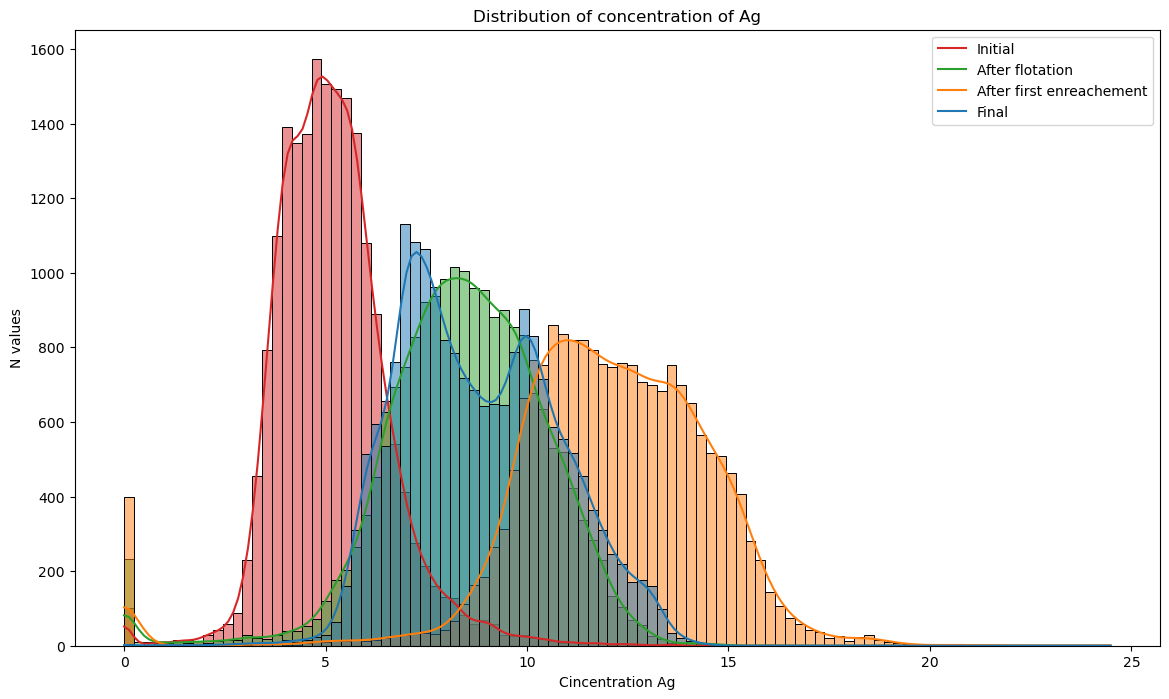

In [9]:
new_vizualization_option('Ag', data_full, 'rougher.input.feed_ag', 'rougher.output.concentrate_ag',
                            'primary_cleaner.output.concentrate_ag',
                             'final.output.concentrate_ag')

**Silver conclusions:**  
Flotation as well as the first stage enriches the mixture with silver.

#### Lead concentration

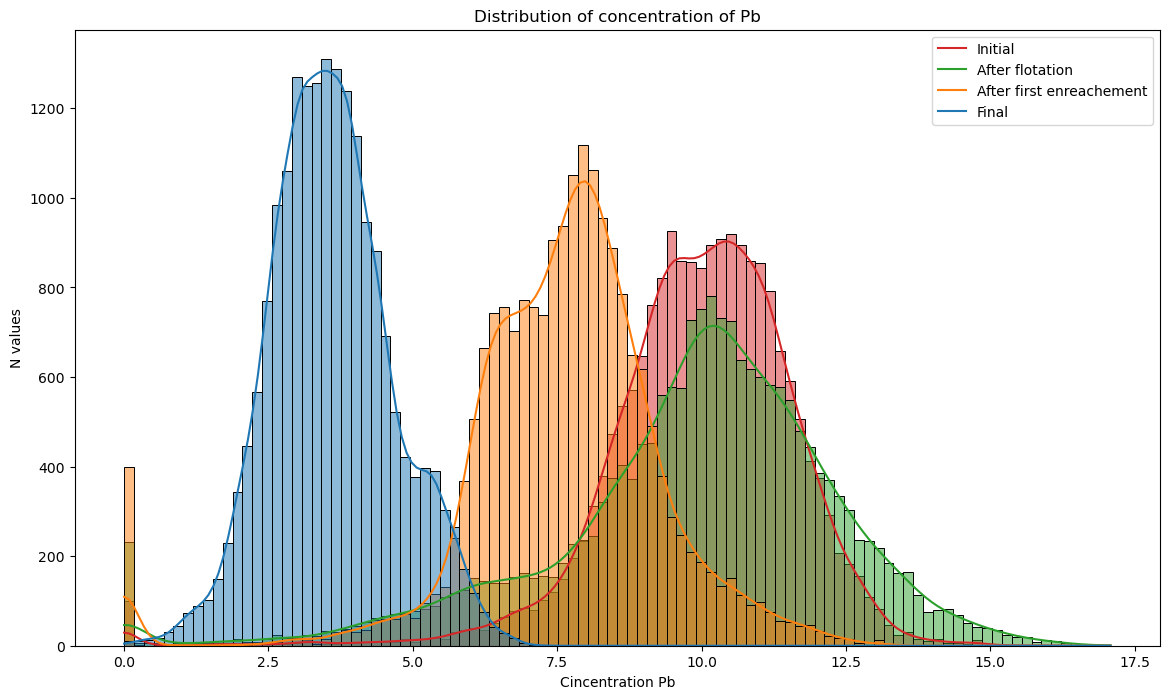

In [10]:
new_vizualization_option('Pb', data_full, 'rougher.input.feed_pb', 'rougher.output.concentrate_pb',
                             'primary_cleaner.output.concentrate_pb',
                              'final.output.concentrate_pb')

**Lead conclusions:**  
Flotation and the second and final stages enrich the mixture with lead.

#### Gold concentration

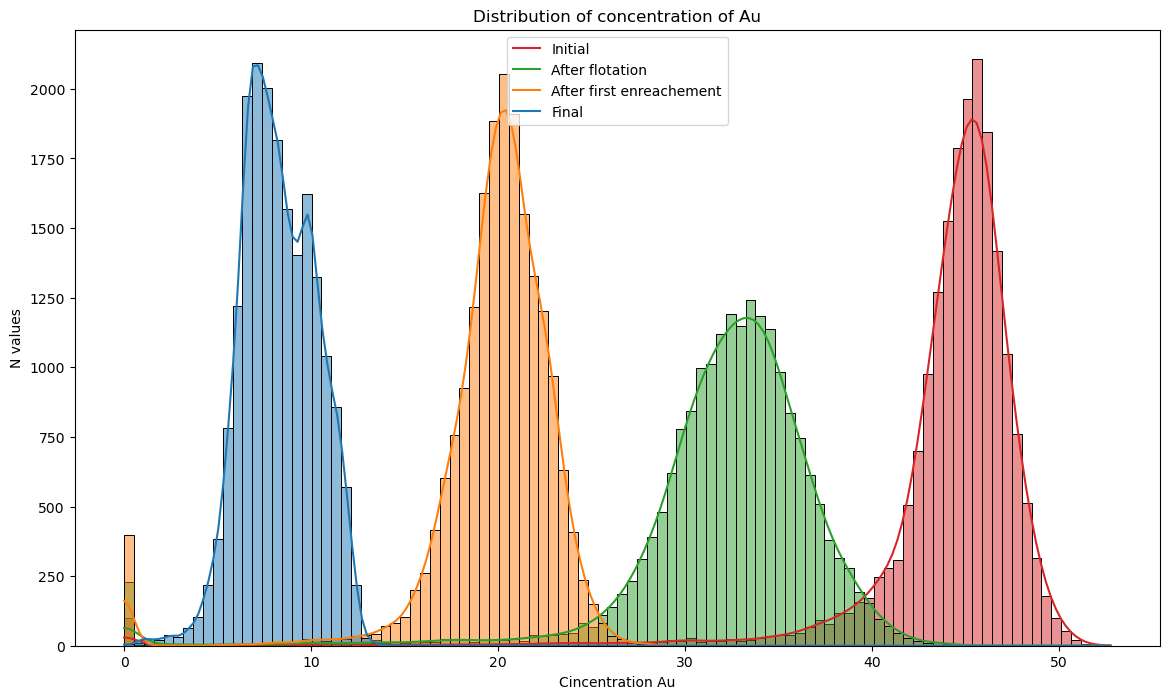

In [11]:
new_vizualization_option('Au', data_full, 'rougher.input.feed_au', 'rougher.output.concentrate_au',
                             'primary_cleaner.output.concentrate_au',
                              'final.output.concentrate_au')

**Gold conclusions:**  
Flotation enriches the mixture with gold, the concentration, however, drops after the first cleaning and increases significantly only in the final stage.

### Pellet size distribution
Compare the pellet size distributions of the feedstock in the training and test samples. If the distributions are very different from each other, the model estimation will be incorrect.

In [12]:
def size_analysis(df, size, name, x_scale):
    print(f'Analysis of {name}')
    
    # First, let's plot the overview graph
    plt.figure(figsize=(16,6))
    sns.lineplot(x=df['date'], y=df[size])
    
    # Line for separating training and test datasets
    line_date = pd.to_datetime('2017-12-09 14:00:00', format='%Y-%m-%d %H:%M:%S')
    plt.axvline(line_date, 0, 1, color='red')
    
    plt.title(label = f'Size of particles {name} over time')
    plt.ylabel('Particles size')
    plt.xlabel('Date')
    plt.show()
    
    # Now let's compare the distribution
    df_train = df[df['date'] < line_date]
    df_test = df[df['date'] > line_date]
    df['which_time'] = df.apply(lambda x: 'Train' if x['date'] < line_date else 'Test', axis=1)
    print('Over whole period:')
    display(df[size].describe())
    print('Train dataset (untill 09.12.17):')
    display(df_train[size].describe())
    print('Test dataset (after 09.12.17):')
    display(df_test[size].describe())
    
    
    # Let's also analyze the distribution graphically
    df_train[size].hist(bins = 50, alpha=0.3, label='Train')
    df_test[size].hist(bins = 50, alpha=0.3, label='Test')
    df[size].hist(bins = 50, alpha=0.3, label='Overall')
    plt.legend(loc='upper right')
    plt.title(label=f'Destribution of particles size {name}', loc='center')
    plt.xlabel("Size")
    plt.ylabel("Quantity")
    plt.xlim(x_scale)
    plt.show()
    
    # Let us also analyze the distribution graphically using boxplot
    fig, axes = plt.subplots(3, 1, figsize=(12, 7))
    sns.boxplot(x=df[size], ax=axes[0])
    axes[0].set_title('Overall')
    sns.boxplot(x=df_train[size], ax=axes[1])
    axes[1].set_title('Train')
    sns.boxplot(x=df_test[size], ax=axes[2])
    axes[2].set_title('Test')
    for i in range(3):
        axes[i].set_xlabel('Size')
    plt.tight_layout()
    plt.show()
    
    # A few additional vizualization to compare how it looks' like
    print('sns.kdeplot')
    plt.figure(figsize=(20,8))
    sns.kdeplot(data=df, x=size, hue="which_time", multiple="stack")
    plt.title(label=f'Destribution of particle size {name}')
       
    plt.xlabel("Size")
    plt.ylabel("Quantity")
    plt.legend(labels=['Train', 'Test'])
    plt.show()
    
    
    print('histplot')
    plt.figure(figsize=(20,8))
    sns.histplot(data=df, x=size, hue="which_time", bins=100, kde=True)
    
    plt.title(label=f'Destribution of particle size {name}')
    plt.xlabel("Size")
    plt.ylabel("Quantity")
    plt.legend(labels=['Train', 'Test'])
    plt.show()  
    
    
    return
 

Analysis of before flotation


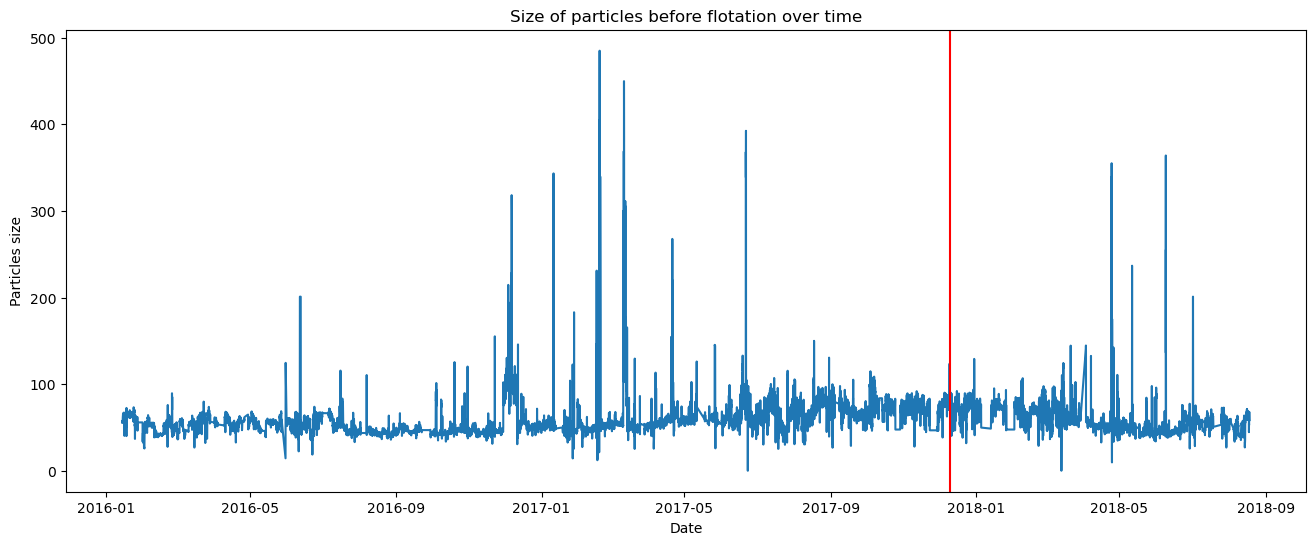

Over whole period:


count    19294.000000
mean        58.970310
std         21.634478
min          0.046369
25%         47.435103
50%         54.610197
75%         65.023044
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Train dataset (untill 09.12.17):


count    14478.000000
mean        58.922712
std         22.407410
min          0.049194
25%         47.278490
50%         54.361187
75%         64.464926
max        484.967466
Name: rougher.input.feed_size, dtype: float64

Test dataset (after 09.12.17):


count    4816.000000
mean       59.113400
std        19.125122
min         0.046369
25%        47.596984
50%        55.509481
75%        66.661547
max       363.989699
Name: rougher.input.feed_size, dtype: float64

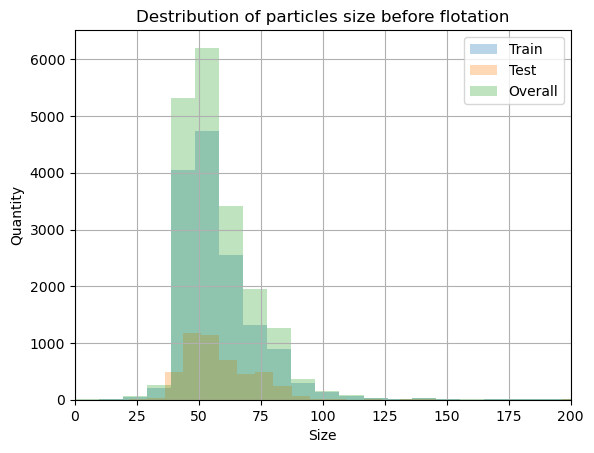

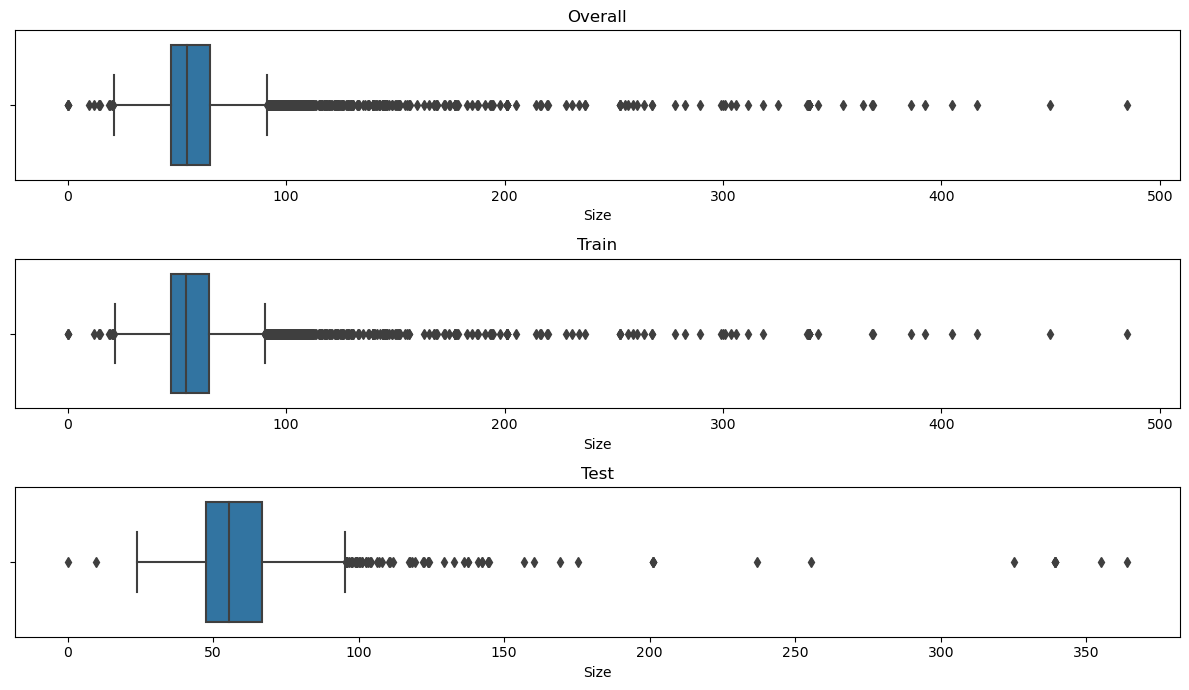

sns.kdeplot


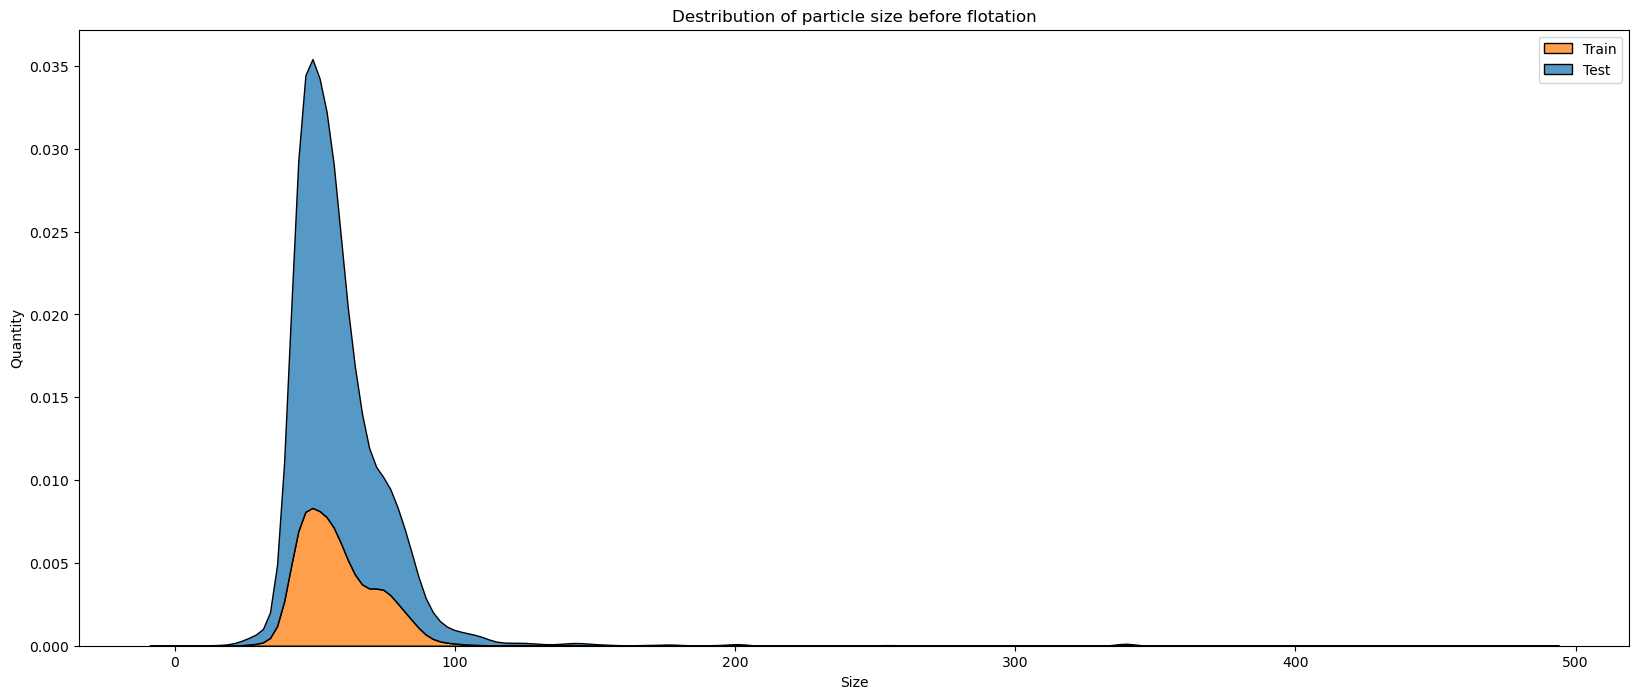

histplot


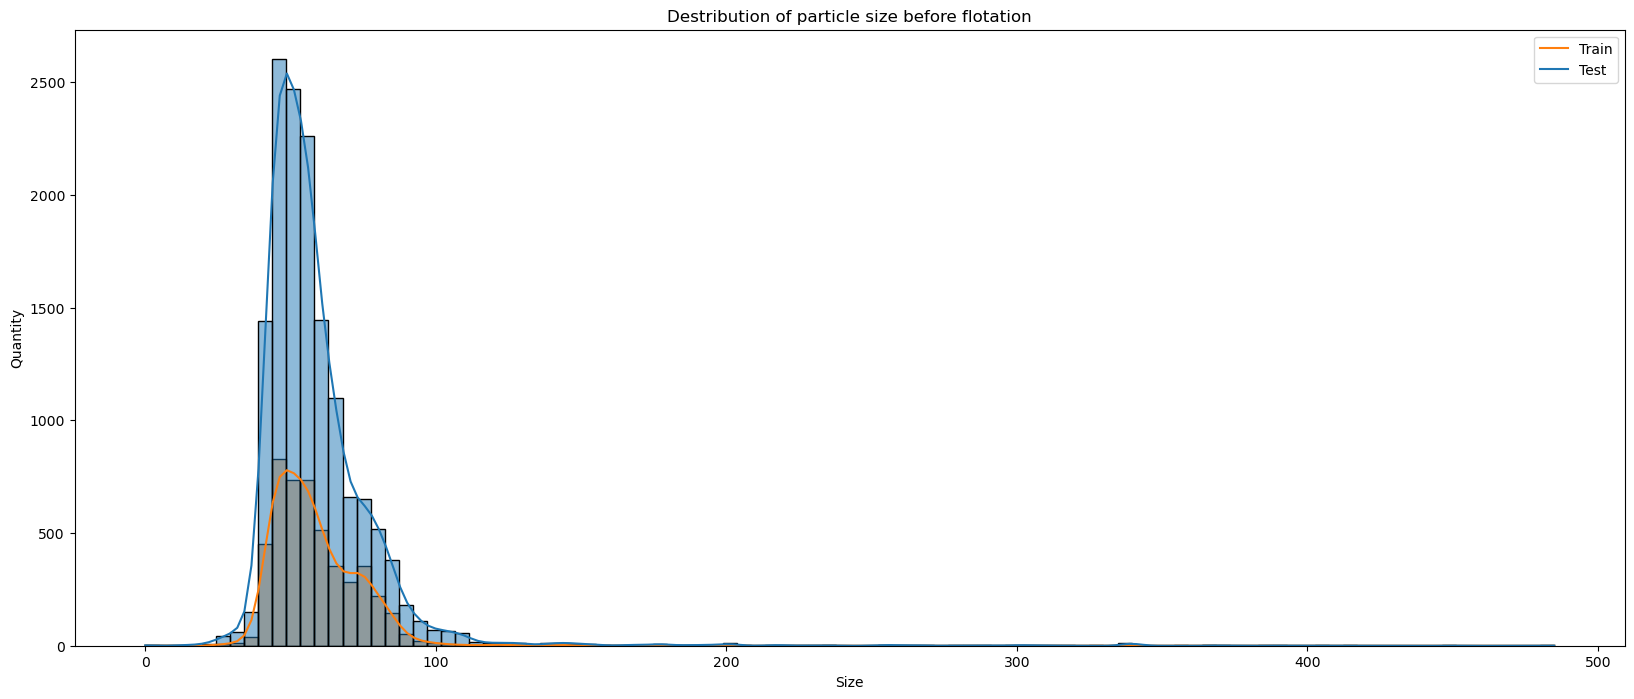

In [13]:
size_analysis(data_full, 'rougher.input.feed_size', 'before flotation', (0, 200))
print('\n\n\n\n\n\n')


Analysis of after flotation


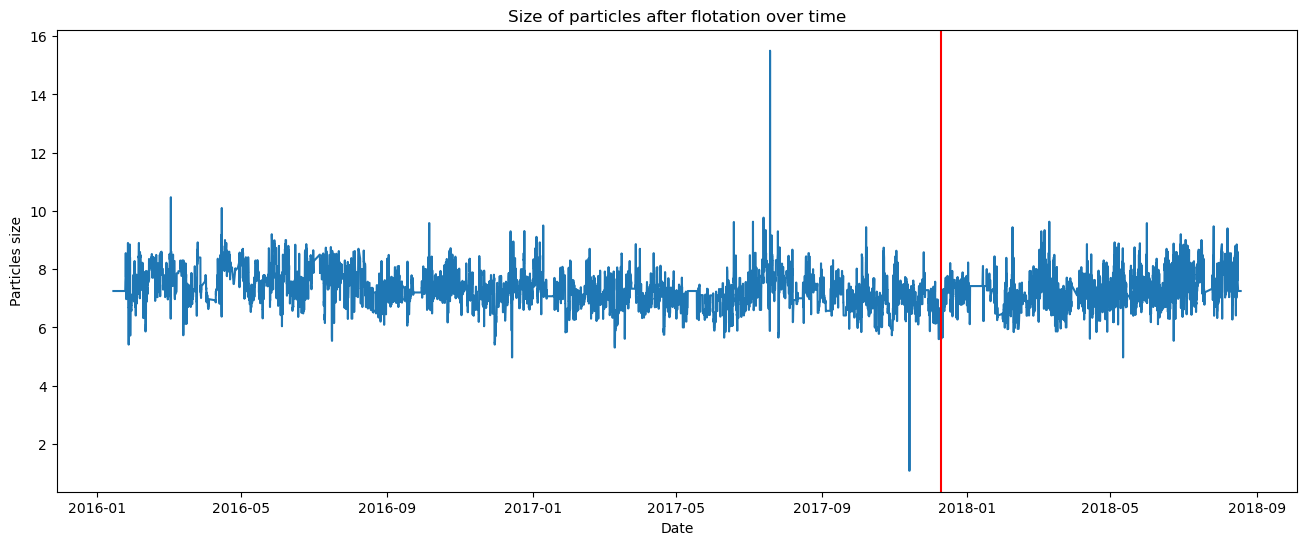

Over whole period:


count    19439.000000
mean         7.307078
std          0.613509
min          1.080000
25%          6.940000
50%          7.280000
75%          7.670000
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Train dataset (untill 09.12.17):


count    14579.000000
mean         7.307600
std          0.621609
min          1.080000
25%          6.940000
50%          7.280000
75%          7.689666
max         15.500000
Name: primary_cleaner.input.feed_size, dtype: float64

Test dataset (after 09.12.17):


count    4860.000000
mean        7.305514
std         0.588602
min         4.970000
25%         6.940000
50%         7.290000
75%         7.630000
max         9.630000
Name: primary_cleaner.input.feed_size, dtype: float64

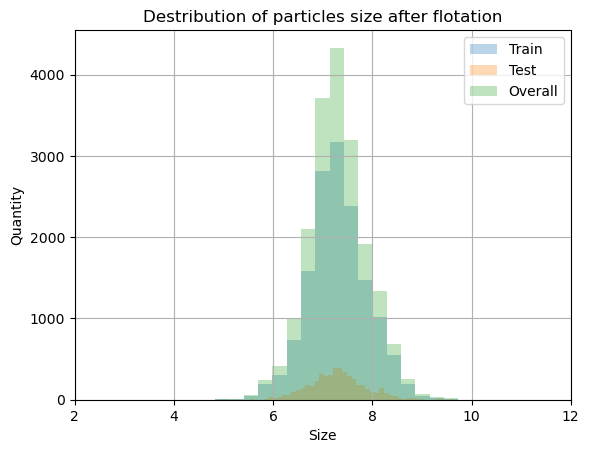

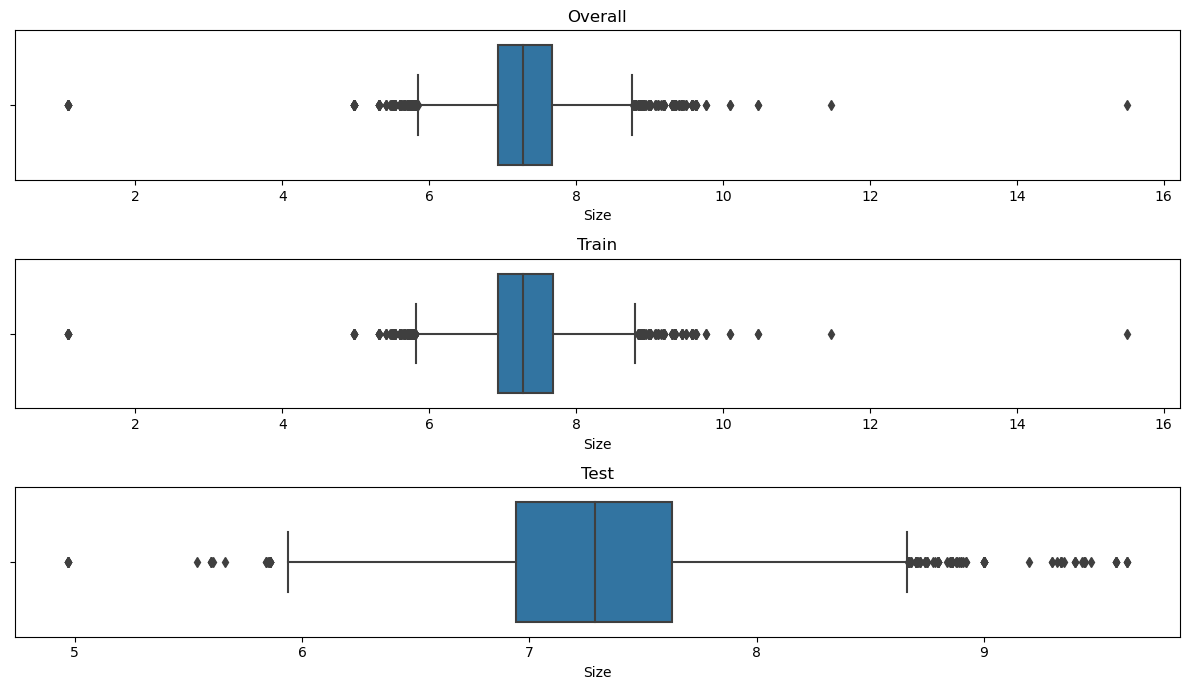

sns.kdeplot


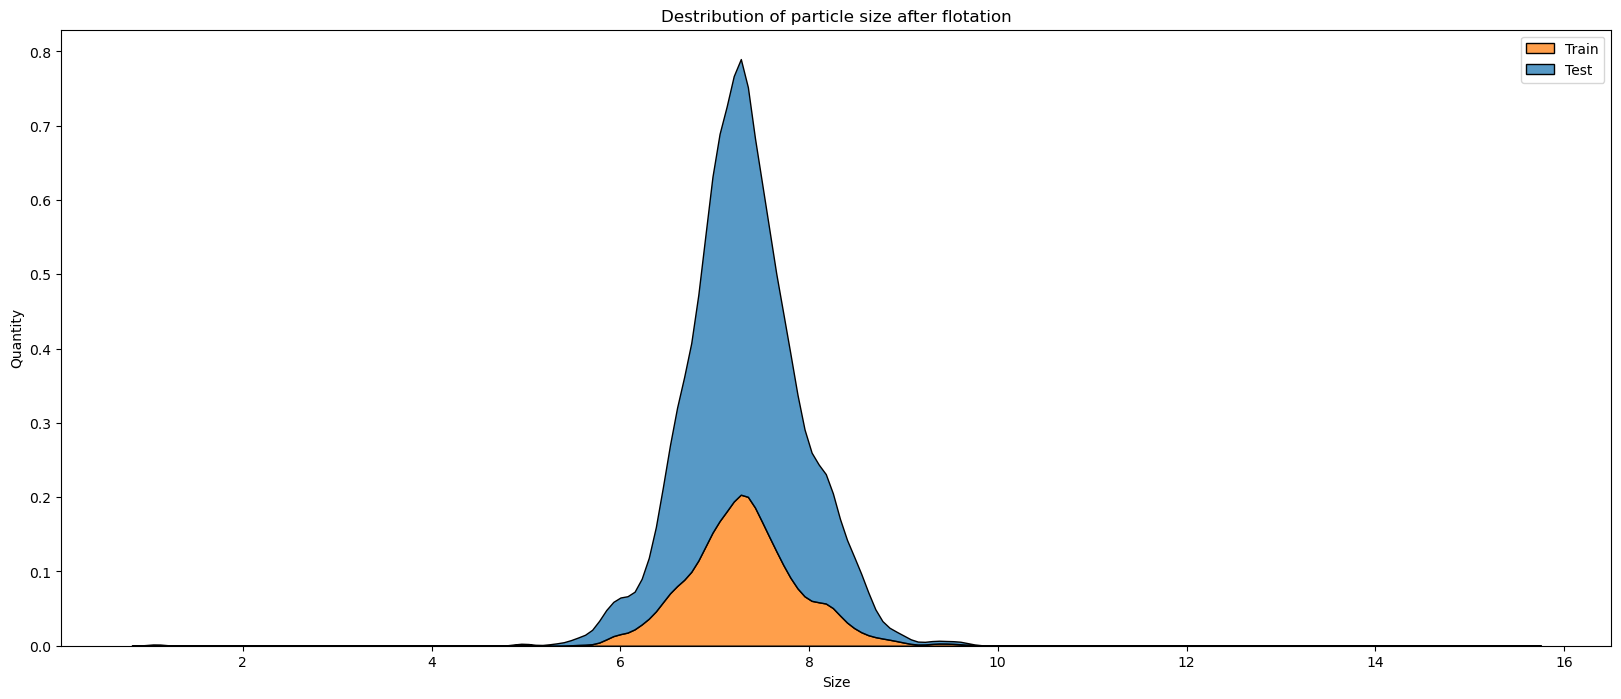

histplot


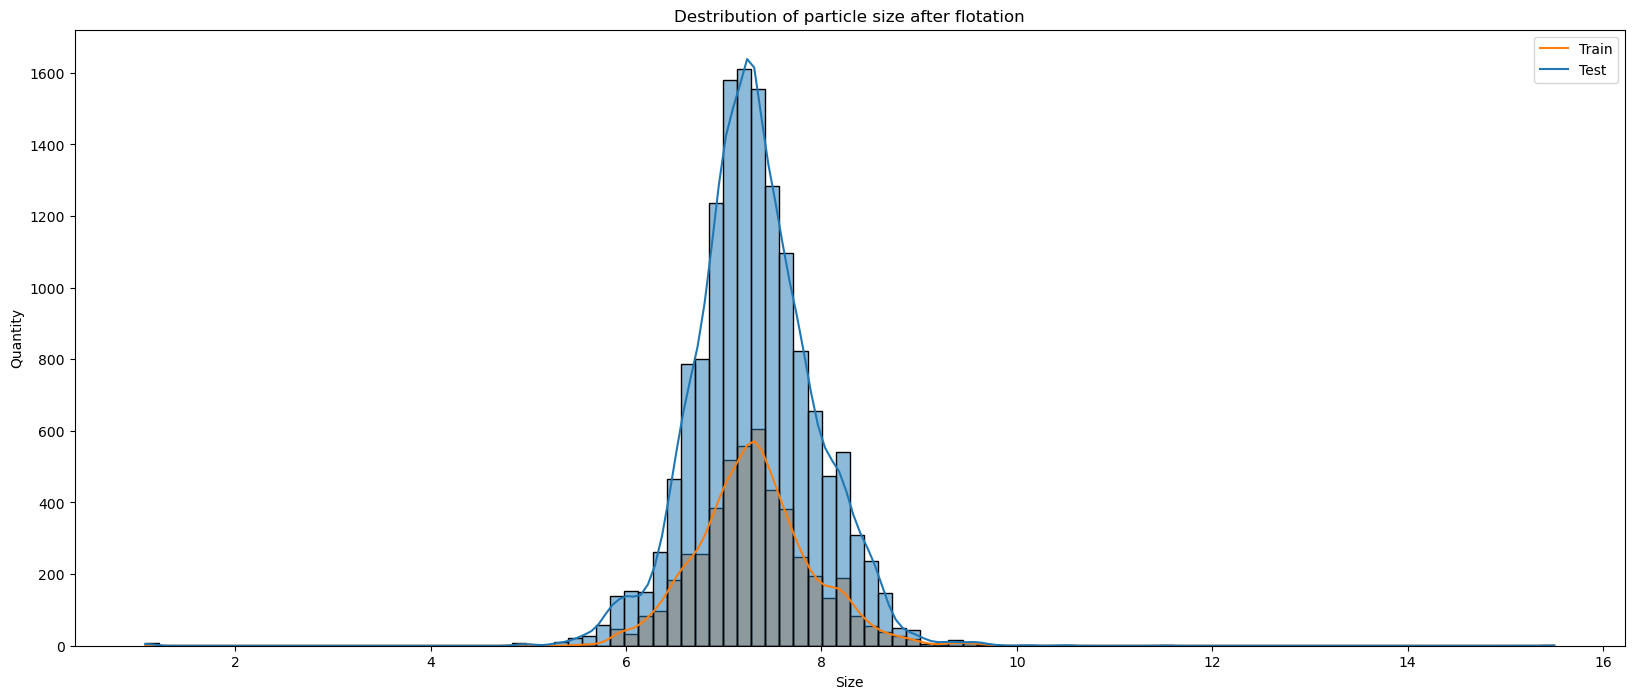

In [14]:
size_analysis(data_full, 'primary_cleaner.input.feed_size', 'after flotation', (2, 12))

**Conclusion:**  
The distributions of chatice are general for the test and training samples.  
It is characteristic both for the particle size before flotation and before the first cleaning.  
At the same time, one cannot help but notice a rather large number of outliers especially characteristic for the particles before flotation.  
However, we will not remove them, because if the problem has not been solved, it is clearly a peculiarity of the technical process and it is better to predict it in its entirety.

### Total Metal Concentration
We study the total concentration of metals at different stages: in the raw material, in the rough concentrate, in the concentrate after the first purification and in the final concentrate.

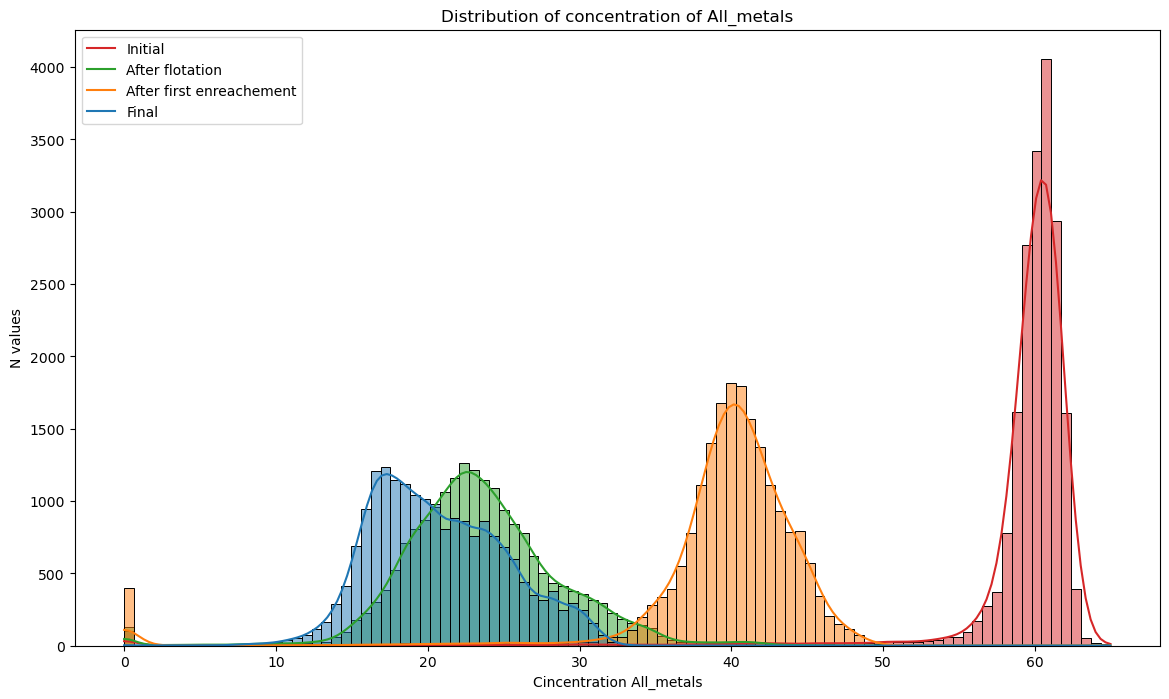

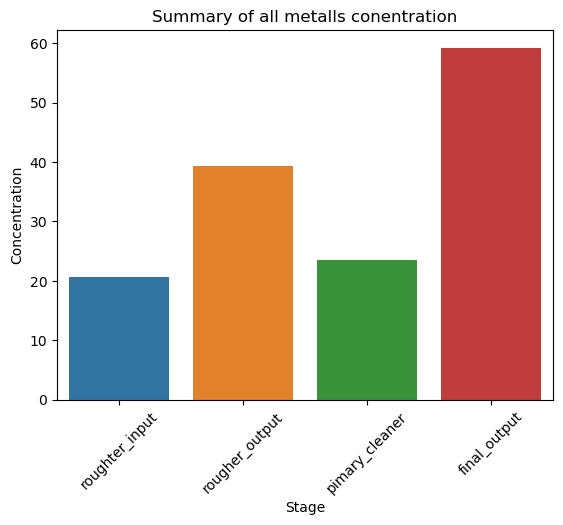

In [15]:
# Total concentration of metals - new parametrs
data_full['roughter_input'] = (data_full['rougher.input.feed_au'] 
                 + data_full['rougher.input.feed_ag']
                 + data_full['rougher.input.feed_pb']
)

data_full['rougher_output'] = (data_full['rougher.output.concentrate_au'] 
                 + data_full['rougher.output.concentrate_ag']
                 + data_full['rougher.output.concentrate_pb']
)

data_full['pimary_cleaner'] = (data_full['primary_cleaner.output.tail_au'] 
                 + data_full['primary_cleaner.output.tail_ag']
                 + data_full['primary_cleaner.output.tail_pb']
)

data_full['final_output'] = (data_full['final.output.concentrate_au'] 
                 + data_full['final.output.concentrate_ag']
                 + data_full['final.output.concentrate_pb']
)

new_vizualization_option('All_metals', data_full, 'roughter_input', 'rougher_output',
                             'pimary_cleaner', 'final_output')


mean_values_for_review = data_full.loc[:, data_full.columns != 'date'].mean(numeric_only=True, axis=0)

indexes_for_outputs_all = ['roughter_input', 'rougher_output',
                             'pimary_cleaner', 'final_output'
                             ]
sns.barplot(x = indexes_for_outputs_all, y = mean_values_for_review[indexes_for_outputs_all])
   
plt.title(f'Summary of all metalls conentration')
plt.xlabel('Stage')
plt.xticks(rotation=45)
plt.ylabel('Concentration')
plt.show()

The concentration of all metals increases after flotation, but decreases after purification and a strong increase is only noticeable after the final stage.

### Temporal changes?
It is interesting to see how the parameters change over time (and therefore for different datasets).  
Let's use the simplified function from point 2.2

Analysis concentration of Au in starting mixture


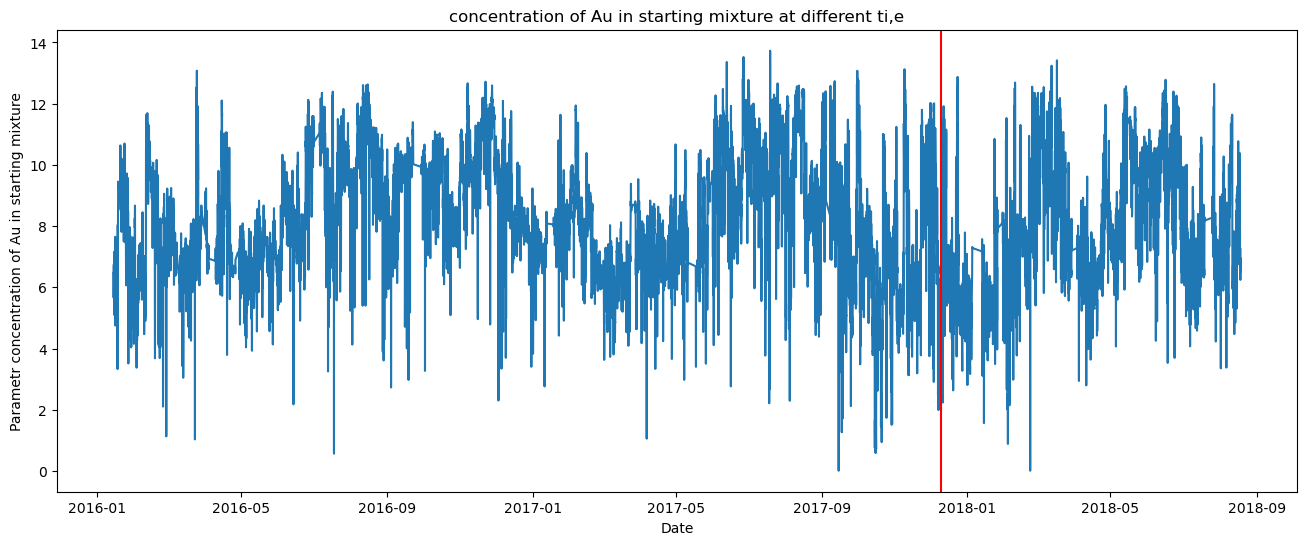

Overll all time:


count    19439.000000
mean         8.266097
std          1.955092
min          0.010000
25%          6.854384
50%          8.125839
75%          9.769917
max         13.731330
Name: rougher.input.feed_au, dtype: float64

For train dataset (before 09.12.17):


count    14579.000000
mean         8.352941
std          1.934376
min          0.010000
25%          6.932996
50%          8.225284
75%          9.832210
max         13.731330
Name: rougher.input.feed_au, dtype: float64

For test dataset (after 09.12.17):


count    4860.000000
mean        8.005584
std         1.993590
min         0.010000
25%         6.574363
50%         7.812923
75%         9.556589
max        13.417156
Name: rougher.input.feed_au, dtype: float64

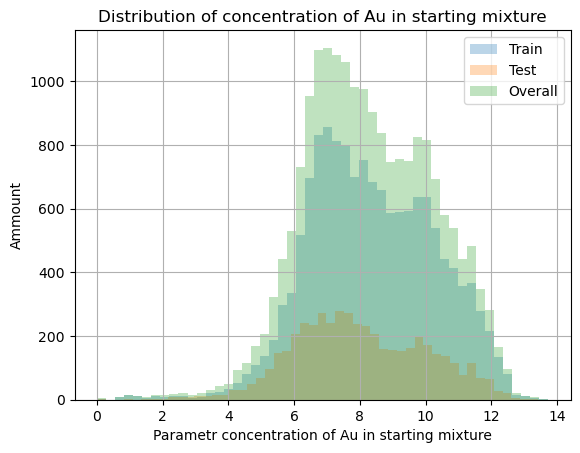

Analysis final conentration of gold


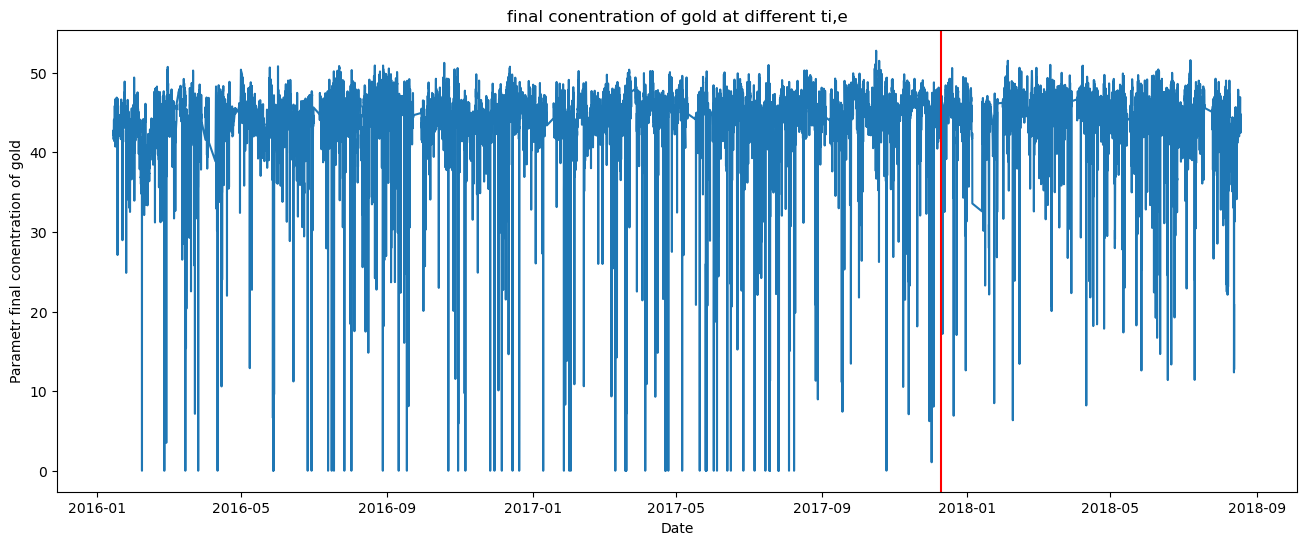

Overll all time:


count    19439.000000
mean        44.076513
std          5.129784
min          0.000000
25%         43.402215
50%         45.011244
75%         46.275313
max         52.756638
Name: final.output.concentrate_au, dtype: float64

For train dataset (before 09.12.17):


count    14579.000000
mean        43.979499
std          5.471437
min          0.000000
25%         43.345906
50%         44.975014
75%         46.275153
max         52.756638
Name: final.output.concentrate_au, dtype: float64

For test dataset (after 09.12.17):


count    4860.000000
mean       44.367534
std         3.916704
min         6.340183
25%        43.559131
50%        45.088025
75%        46.277022
max        51.571885
Name: final.output.concentrate_au, dtype: float64

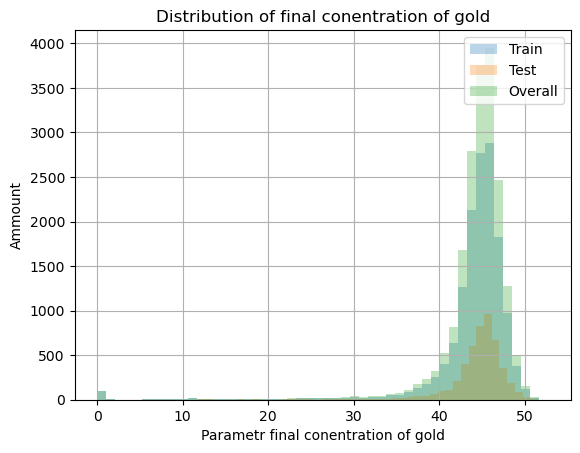

Analysis recovery after flotation


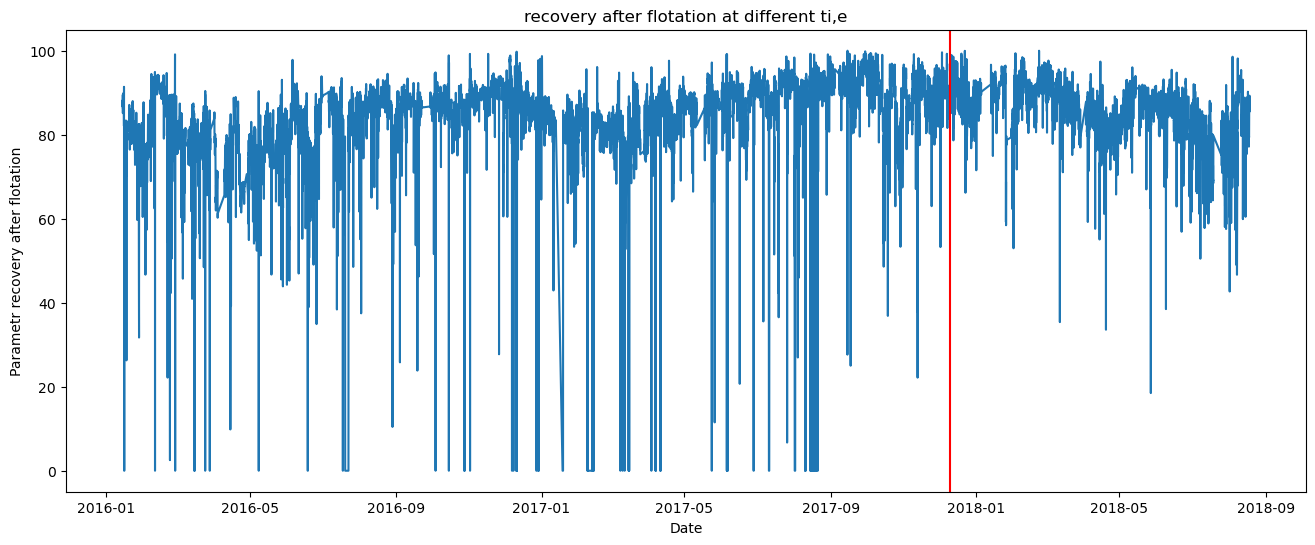

Overll all time:


count    19439.000000
mean        83.328587
std         14.148086
min          0.000000
25%         81.037957
50%         86.188892
75%         90.010670
max        100.000000
Name: rougher.output.recovery, dtype: float64

For train dataset (before 09.12.17):


count    14579.000000
mean        82.521200
std         15.797521
min          0.000000
25%         80.558542
50%         85.946497
75%         89.960375
max        100.000000
Name: rougher.output.recovery, dtype: float64

For test dataset (after 09.12.17):


count    4860.000000
mean       85.750584
std         6.648023
min        18.491446
25%        82.354512
50%        86.839027
75%        90.145117
max       100.000000
Name: rougher.output.recovery, dtype: float64

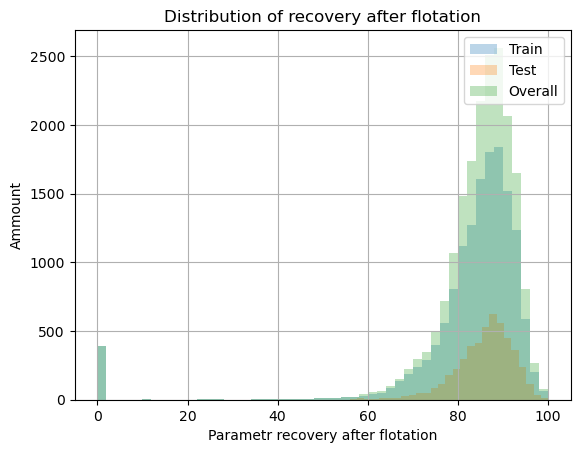

Analysis recovery at the final stage


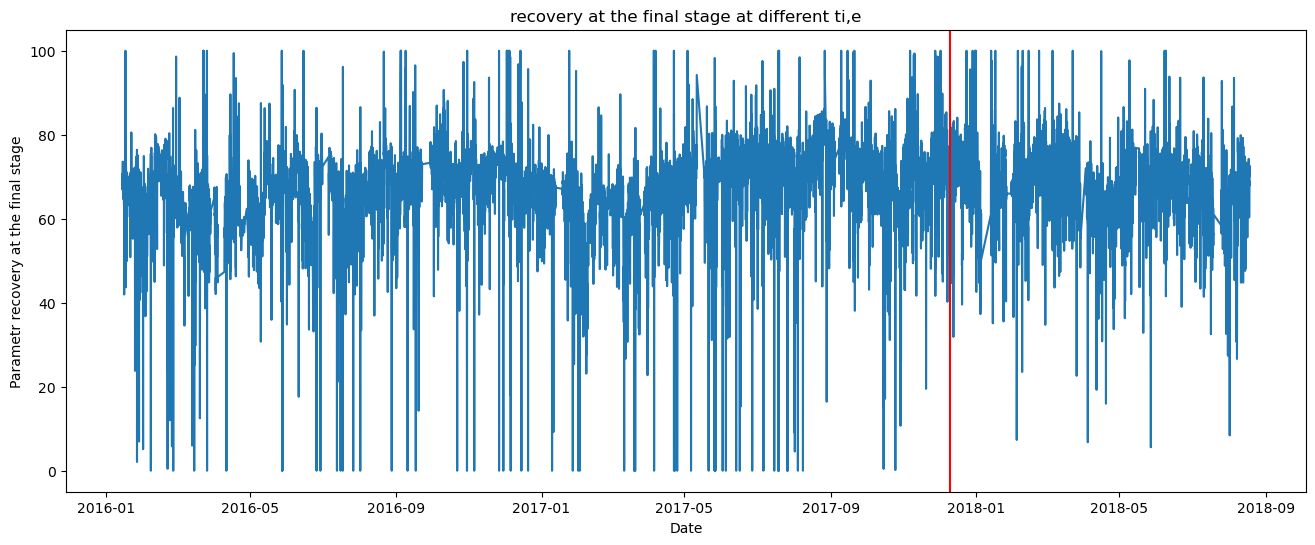

Overll all time:


count    19439.000000
mean        67.050208
std         10.125840
min          0.000000
25%         63.299712
50%         68.172738
75%         72.686642
max        100.000000
Name: final.output.recovery, dtype: float64

For train dataset (before 09.12.17):


count    14579.000000
mean        66.759066
std         10.619709
min          0.000000
25%         63.114596
50%         67.962788
75%         72.598187
max        100.000000
Name: final.output.recovery, dtype: float64

For test dataset (after 09.12.17):


count    4860.000000
mean       67.923574
std         8.414134
min         5.586496
25%        63.939233
50%        68.744713
75%        73.037434
max       100.000000
Name: final.output.recovery, dtype: float64

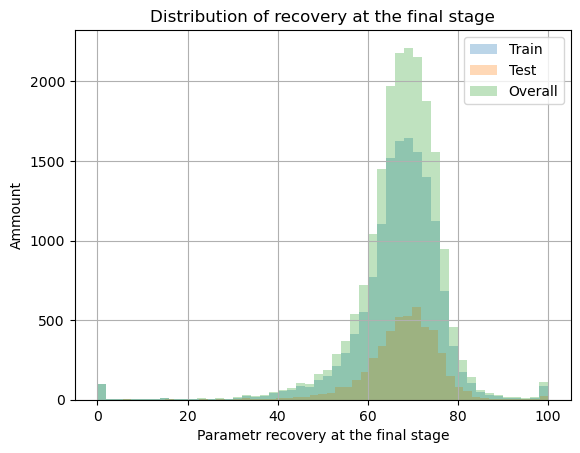

In [16]:
def parametr_analysis(df, parametr, name):
    print(f'Analysis {name}')
    
    # Overview
    plt.figure(figsize=(16,6))
    sns.lineplot(x=df['date'], y=df[parametr])

    line_date = pd.to_datetime('2017-12-09 14:00:00', format='%Y-%m-%d %H:%M:%S')
    plt.axvline(line_date, 0, 1, color='red')
    
    plt.title(label=f'{name} at different ti,e')
    plt.ylabel(f'Parametr {name}')
    plt.xlabel('Date')
    plt.show()
    
    # Let's compare distributions
    df_train = df[df['date'] < line_date]
    df_test = df[df['date'] > line_date]
    print('Overll all time:')
    display(df[parametr].describe())
    print('For train dataset (before 09.12.17):')
    display(df_train[parametr].describe())
    print('For test dataset (after 09.12.17):')
    display(df_test[parametr].describe())
    
    df_train[parametr].hist(bins = 50, alpha=0.3, label='Train')
    df_test[parametr].hist(bins = 50, alpha=0.3, label='Test')
    df[parametr].hist(bins = 50, alpha=0.3, label='Overall')
    plt.legend(loc='upper right')
    plt.title(label=f'Distribution of {name}', loc='center')
    plt.xlabel(f"Parametr {name}")
    plt.ylabel("Ammount")
    plt.show()
    
    return

parametr_analysis(data_full, 'rougher.input.feed_au', 'concentration of Au in starting mixture')
parametr_analysis(data_full, 'final.output.concentrate_au', 'final conentration of gold')
parametr_analysis(data_full, 'rougher.output.recovery', 'recovery after flotation')
parametr_analysis(data_full, 'final.output.recovery', 'recovery at the final stage')

No noticeable variation over time was found.  
It is interesting that the concentration of gold in the raw material is very variable.

### Conclusions  
The **concentration of metals** at different stages of the processes has been studied and it is shown that:  
The concentration of silver in the mixture increases before the second purification, and decreases sharply at the final stage.
Flotation enriches the mixture with gold, the concentration, however, falls after the first purification and increases significantly only at the final stage.  
Flotation, as well as the second and final stages, enriches the mixture with lead.  
In this case, the concentration of all metals increases after flotation, but decreases after cleaning and a strong increase is noticeable only after the final stage.  

**Analysis of data from time**
The particle distribution was examined and shown to be general for the test and training samples.    
This is characteristic of both the particle size before flotation and before the first cleaning.  
Analysis of the additional parameters from time also showed that the data for the test and training samples are not significantly different.

## Model  
Different models need to be trained for prediction, via the following:  
1. Write a function to compute the final sMAPE.  
2. Train different models and evaluate their quality by cross validation.  
3. Select the best model and validate it on a test sample.  
4. Describe the conclusions.

### Function to calculate the total sMAPE


In [17]:
def sMAPE(recovery_known, predictions_recovery):
    smape_value = 0
    for i in range(len(predictions_recovery)):
        smape_value += 2 * np.abs(predictions_recovery[i] - recovery_known[i]) / (
            np.abs(predictions_recovery[i]) + np.abs(recovery_known[i]))
    smape_value = 100 * smape_value / (len(predictions_recovery))  
    return smape_value

def final_sMAPE(sMAPE_rougher, sMAPE_final):
    final_smape =( 0.25 * sMAPE_rougher
                + 0.75 * sMAPE_final)
    return final_smape


sMAPE_scorer = make_scorer(sMAPE, greater_is_better=False)

### Model Training
#### Preparing and splitting samples
It is necessary to perform some additional operations - to leave only necessary columns, to make the date an index and to divide the training sample into training and validation samples.

In [18]:
# In all datasets, let's make the date an index
data_test.set_index('date', inplace=True)
data_train.set_index('date', inplace=True)
data_full.set_index('date', inplace=True)

# It is necessary to select the features, the simplest case is flotation, 
# we will select only those columns where there are
# rougher.calculation , rougher.input или rougher.state
target_rougher = 'rougher.output.recovery'
features_rougher = []
features_final_full = []

for col_name in data_full.columns:
    if ('rougher.state' in col_name
       # or 'rougher.calculation' in col_name 
        #we don't take into account the calculated signs
        or 'rougher.input' in col_name
       ):
        features_rougher.append(col_name)
        features_final_full.append(col_name)

# The overall stage is not so clear-cut, you can either use only the data available after flotation
# or use all of it
# data for all additions from the beginning
# Let's check both versions - final_full - all data, final - only data after flotation

target_final = 'final.output.recovery'

features_final = []

for col_name in data_full.columns:
    if ('primary_cleaner.input' in col_name
        or 'primary_cleaner.state' in col_name
        or 'secondary_cleaner.state' in col_name):
        features_final.append(col_name)
        features_final_full.append(col_name)

print('features_rougher:', features_rougher, '\n')
print('\033[1m', 'Total features_rougher:', len(features_rougher), '\033[0m', '\n')
print('features_final:', features_final, '\n')
print('\033[1m', 'Total features_final:', len(features_final), '\033[0m', '\n')
print('\033[1m', 'Total features_final_full:', len(features_final_full), '\033[0m')

features_rougher: ['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_sol', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.state.floatbank10_a_air', 'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air', 'rougher.state.floatbank10_f_level', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate'] 

 Total features_rougher: 22  

features_final: ['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate', 'primary_cleaner.state.floatbank8_a_air', 'primary_clean

Once we have a complete list of all the data, we can break down the samples.

In [19]:
# We need to get three different sets of features, 2 different sets of targets, all on 3 datasets
# train, which we need to split into train and valid and test

# Lists dataframes and columns for targets & features
all_targets = [target_rougher, target_final]
all_features = [features_rougher, features_final, features_final_full]
all_df = [data_train, data_test]

# Check
# columns_missing = [column for column in features_final_full if column not in train_df.columns]
# print(columns_missing)


rougher_target_train = data_train[target_rougher]
rougher_target_test = data_test[target_rougher]

final_target_train = data_train[target_final]
final_target_test = data_test[target_final]

# Replace all null target values with tending to zero to preserve data but not cause division by zero
def fill_zeros(df):
    return np.where(df == 0, 0.00000001, df)

rougher_target_train = fill_zeros(rougher_target_train)
rougher_target_test = fill_zeros(rougher_target_test)
final_target_train = fill_zeros(final_target_train)
final_target_test = fill_zeros(final_target_test)

rougher_features_train = data_train[features_rougher]
rougher_features_test = data_test[features_rougher]

final_features_train = data_train[features_final]
final_features_test = data_test[features_final]

final_features_full_train = data_train[features_final_full]
final_features_full_test = data_test[features_final_full]

#### Functions for model training
Let's create three functions - for linear regression, decision tree, and random forest, so that we can use them on all samples.

##### Linear regression

In [20]:
# Let's create a list for predictions, models and comments
model_list = pd.DataFrame({
                    'name': [],
                    'sMAPE': [],
                    'comments': [],
                    'model': []
})

def linear_regression_model(train_features, train_targets, identifier):
    global model_list
         
    # train the model using cross-validation and calculate smape
    model = LinearRegression()
    scores = -cross_val_score(model, train_features, train_targets, scoring=sMAPE_scorer, cv=5)
    smape_value = sum(scores) / len(scores)
    
    model.fit(train_features, train_targets)
    
    name = f'linear_regresion for {identifier}'
    comment = ' '
    new_row = {'name': name, 'sMAPE': smape_value, 'comments': comment, 'model': model}
    model_list = model_list.append(new_row, ignore_index=True)
    
    print(f'Linear regression model {identifier}, sMAPE = {smape_value}')
    print('\n')
    
    return

##### Decision tree

In [21]:
def tree_optimization(train_features, train_targets, identifier):
    global model_list
    
    best_model_tree = None
    best_result_tree = 100_000_000
    best_depth = 0
    
    print('\n')
    print('\033[1m', 
          f'Lets discuss {identifier}',
         '\033[0m')
    
    for depth in range(1, 15, 2):
        model = DecisionTreeRegressor(max_depth = depth, random_state = 44)
        scores = -cross_val_score(model, train_features, train_targets, scoring=sMAPE_scorer, cv=5)
        smape_value = sum(scores) / len(scores)
        
        model.fit(train_features, train_targets)
    
        print(f'Decision tree model for {identifier}, depth = {depth}, sMAPE = {smape_value}')

        if smape_value < best_result_tree:
            best_model_tree = model
            best_result_tree = smape_value
            best_depth = depth
 
    name = f'decision_tree for {identifier}'
    comment = f'depth = {best_depth}'
    new_row = {'name': name, 'sMAPE': best_result_tree, 'comments': comment, 'model': best_model_tree}
    model_list = model_list.append(new_row, ignore_index=True)
    
    
    print('\n')
    print('\033[1m', 
          f'The best decision tree for {identifier}, depth = {best_depth} sMAPE = {best_result_tree}',
         '\033[0m')
    print('\n')
    
    return

##### Random forest

In [22]:
def random_forest_optimization(train_features, train_targets, identifier):
    global model_list
    
    best_model_forest = None
    best_result_forest = 100_000_000
    best_est_forest = 0
    best_depth_forest = 0
    
    print('\n')
    print('\033[1m', 
          f'Lets discuss {identifier}',
         '\033[0m')
    
    for est in range(2, 43, 20):
        print('Number of tress:', est)
        for depth in range (1, 11, 2):
            model = RandomForestRegressor(random_state = 44, n_estimators=est, max_depth=depth)
            scores = -cross_val_score(model, train_features, train_targets, scoring=sMAPE_scorer, cv=5)
            smape_value = sum(scores) / len(scores)
            
            model.fit(train_features, train_targets)
            
            print(f"Max depth = {depth}, sMAPE = {smape_value}")

            if smape_value < best_result_forest:
                best_model_forest = model
                best_result_forest = smape_value
                best_est_forest = est
                best_depth_forest = depth  
        print('\n')
    
    name = f'random_forest for {identifier}'
    comment = f'number of trees = {best_est_forest}, depth = {best_depth_forest}'
    new_row = {'name': name, 'sMAPE': best_result_forest, 'comments': comment, 'model': best_model_forest}
    model_list = model_list.append(new_row, ignore_index=True)            
        
    print('\n')
    print('\033[1m', 
          f'The best random forest model for {identifier}, number of trees = {best_est_forest},',
          f'depth = {best_depth_forest} sMAPE = {best_result_forest}',
         '\033[0m')
    print('\n')
    
    return

#### Models Training

In [23]:
linear_regression_model(rougher_features_train, rougher_target_train,
                        'rougher')

linear_regression_model(final_features_train, final_target_train,
                        'final')

linear_regression_model(final_features_full_train, final_target_train,
                        'final_full')

Linear regression model rougher, sMAPE = 12.799127589159614


Linear regression model final, sMAPE = 10.935211000265854


Linear regression model final_full, sMAPE = 11.364566278185844




In [24]:
tree_optimization(rougher_features_train, rougher_target_train,
                        'rougher')

tree_optimization(final_features_train, final_target_train,
                        'final')

tree_optimization(final_features_full_train, final_target_train,
                        'final_full')



 Lets discuss rougher 
Decision tree model for rougher, depth = 1, sMAPE = 14.742809440043146
Decision tree model for rougher, depth = 3, sMAPE = 13.29959412400089
Decision tree model for rougher, depth = 5, sMAPE = 12.94292071424726
Decision tree model for rougher, depth = 7, sMAPE = 13.880835881842199
Decision tree model for rougher, depth = 9, sMAPE = 14.456836227402238
Decision tree model for rougher, depth = 11, sMAPE = 21.151654922866264
Decision tree model for rougher, depth = 13, sMAPE = 23.222922320005466


 The best decision tree for rougher, depth = 5 sMAPE = 12.94292071424726 




 Lets discuss final 
Decision tree model for final, depth = 1, sMAPE = 11.00843689669004
Decision tree model for final, depth = 3, sMAPE = 10.994598227135581
Decision tree model for final, depth = 5, sMAPE = 11.975583195265994
Decision tree model for final, depth = 7, sMAPE = 14.512214380062488
Decision tree model for final, depth = 9, sMAPE = 17.460154196867194
Decision tree model for final, de

In [25]:
random_forest_optimization(rougher_features_train, rougher_target_train,
                        'rougher')

random_forest_optimization(final_features_train, final_target_train,
                        'final')

random_forest_optimization(final_features_full_train, final_target_train,
                        'final_full')



 Lets discuss rougher 
Number of tress: 2
Max depth = 1, sMAPE = 14.915262127482492
Max depth = 3, sMAPE = 13.315945404228515
Max depth = 5, sMAPE = 14.224602280153082
Max depth = 7, sMAPE = 14.89523436256608
Max depth = 9, sMAPE = 15.726562460335728


Number of tress: 22
Max depth = 1, sMAPE = 14.731589465942317
Max depth = 3, sMAPE = 13.118460414351414
Max depth = 5, sMAPE = 12.812043956451697
Max depth = 7, sMAPE = 13.116121905604867
Max depth = 9, sMAPE = 14.055843462955412


Number of tress: 42
Max depth = 1, sMAPE = 14.72995960404555
Max depth = 3, sMAPE = 13.180401643642503
Max depth = 5, sMAPE = 12.747541875673415
Max depth = 7, sMAPE = 13.288552509609712
Max depth = 9, sMAPE = 14.211684083008901




 The best random forest model for rougher, number of trees = 42, depth = 5 sMAPE = 12.747541875673415 




 Lets discuss final 
Number of tress: 2
Max depth = 1, sMAPE = 10.881453340518728
Max depth = 3, sMAPE = 10.85801333914154
Max depth = 5, sMAPE = 11.62807452676488
Max depth

#### Conclusions
After additional data processing and sample diving, three models were trained: linear regression, decision tree, and random forest. For the latter two models, hyperparameter optimization was also performed. The training results will be discussed in the next section.

### Best model and its validation on a test sample
#### Model Comparison

,name,sMAPE,comments,model
0,linear_regresion for rougher,12.799128,,LinearRegression()
1,linear_regresion for final,10.935211,,LinearRegression()
2,linear_regresion for final_full,11.364566,,LinearRegression()
3,decision_tree for rougher,12.942921,depth = 5,"DecisionTreeRegressor(max_depth=5, random_stat..."
4,decision_tree for final,10.994598,depth = 3,"DecisionTreeRegressor(max_depth=3, random_stat..."
5,decision_tree for final_full,11.008437,depth = 1,"DecisionTreeRegressor(max_depth=1, random_stat..."
6,random_forest for rougher,12.747542,"number of trees = 42, depth = 5","(DecisionTreeRegressor(max_depth=5, max_featur..."
7,random_forest for final,10.587208,"number of trees = 22, depth = 3","(DecisionTreeRegressor(max_depth=3, max_featur..."
8,random_forest for final_full,10.741639,"number of trees = 22, depth = 3","(DecisionTreeRegressor(max_depth=3, max_featur..."


For stage rougher the best model is random_forest for rougher with parametrs number of trees = 42, depth = 5, sMAPE = 12.747541875673415 

For stage final the best model is random_forest for final with parametrs number of trees = 22, depth = 3, sMAPE = 10.587207979974735 

The best final_sMAPE values for training dataset: 11.127291453899405


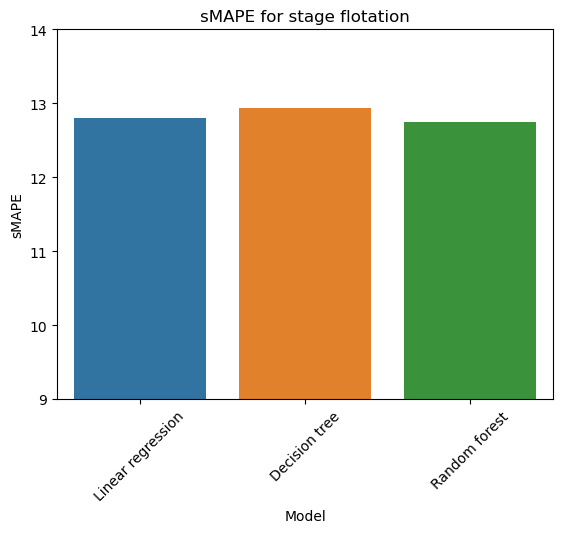

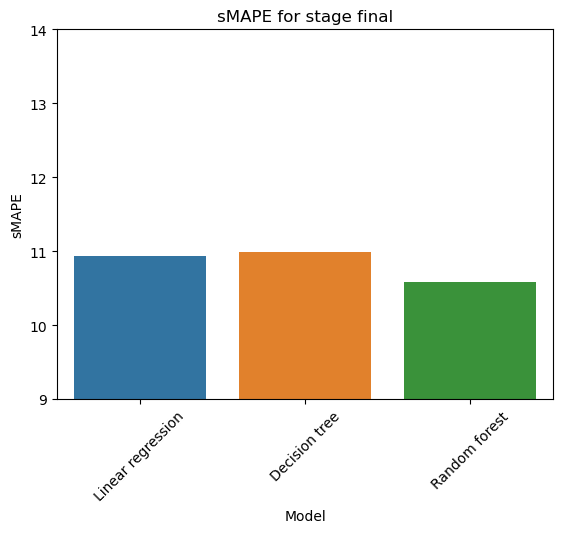

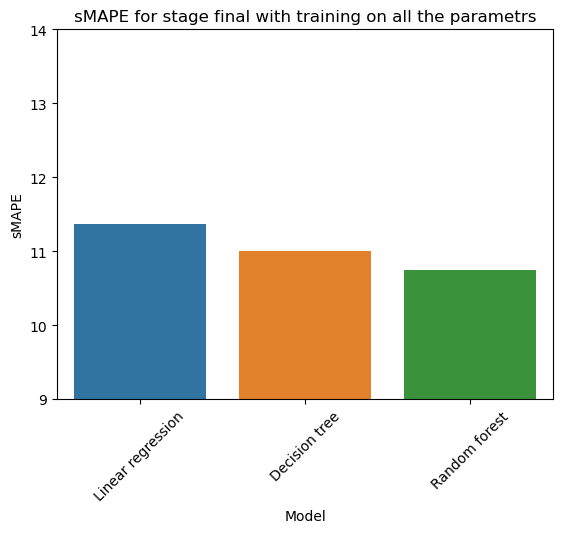

In [26]:
display(model_list)

stages_list = ['rougher', 'final']
best_model_rougher = None
best_model_final = None

# Let's go through all the models for both stages and choose the best one
for stage in stages_list:
    min_value = 100
    row_index = 0
    for row in model_list.index:
        if stage in model_list['name'][row]:
            if model_list['sMAPE'][row] < min_value:
                min_value = model_list['sMAPE'][row]
                row_index = row
                if stage == 'rougher':
                    best_model_rougher = model_list['model'][row]
                else:
                    best_model_final = model_list['model'][row]
    print(f"For stage {stage} the best model is {model_list['name'][row_index]} " 
          f"with parametrs {model_list['comments'][row_index]}, sMAPE = {model_list['sMAPE'][row_index]}",
          '\n')

best_test_final_sMAPE = final_sMAPE(model_list['sMAPE'][6], model_list['sMAPE'][7])
print(f"The best final_sMAPE values for training dataset: {best_test_final_sMAPE}")


# Build graphs to visualize the quality of model predictions
def models_graphyical_representation(name, index_1, index_2, index_3):
    models_for_outputs = [index_1, index_2, index_3]
    sns.barplot(x = models_for_outputs, y = model_list['sMAPE'][models_for_outputs])
    
    plt.xticks(ticks=[0, 1, 2],
               labels=['Linear regression', 'Decision tree', 'Random forest'], rotation=45)
    plt.title(f'sMAPE for stage {name}')
    plt.xlabel('Model')
    plt.ylabel('sMAPE')
    
    plt.ylim(9, 14)
    
    plt.show()
    return

models_graphyical_representation('flotation', 0, 3, 6)
models_graphyical_representation('final', 1, 4, 7)
models_graphyical_representation('final with training on all the parametrs', 2, 5, 8)

Thus, the best models for prediction for both the flotation stage and the last stage turned out to be random forest models. The former with number of trees = 22, depth = 5, the latter with 42 and 3, respectively.  
In general, linear regression and the decisive tree also gave close results.  
It is interesting to note that adding flotation process attributes to the model training for the final stage leads to a deterioration in the predictive power of the model.

#### Test sample
Let's check the best models on a test sample.

In [27]:
predictions_test_rougher = best_model_rougher.predict(rougher_features_test) 
sMAPE_test_rougher = sMAPE(rougher_target_test, predictions_test_rougher)
print('sMAPE_test_rougher:', sMAPE_test_rougher)

predictions_test_final = best_model_final.predict(final_features_test) 
sMAPE_test_final = sMAPE(final_target_test, predictions_test_final)
print('sMAPE_test_final:', sMAPE_test_final)

print('final_sMAPE for test data:', final_sMAPE(sMAPE_test_rougher, sMAPE_test_final))

sMAPE_test_rougher: 5.287879329142675
sMAPE_test_final: 8.203308639007174
final_sMAPE for test data: 7.474451311541049


#### Parametrs input analysis
It is interesting to see why models with small tree depths win. Apparently. there are only a few parameters that really affect output.

For flotation


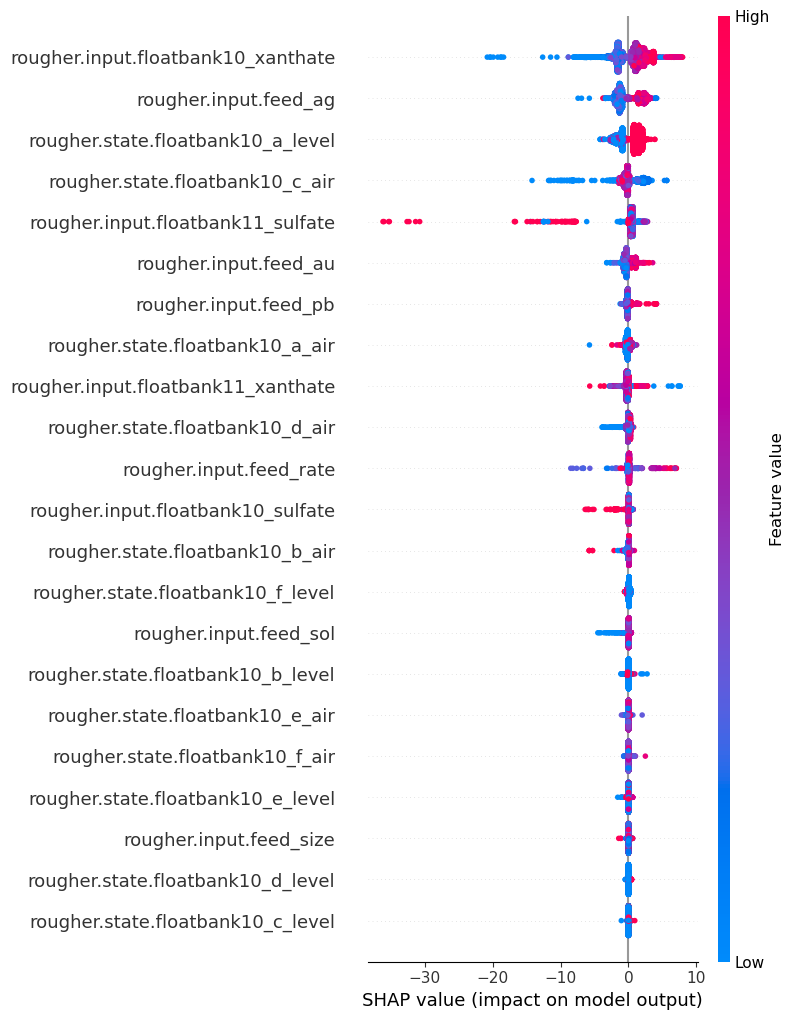



For the final stage


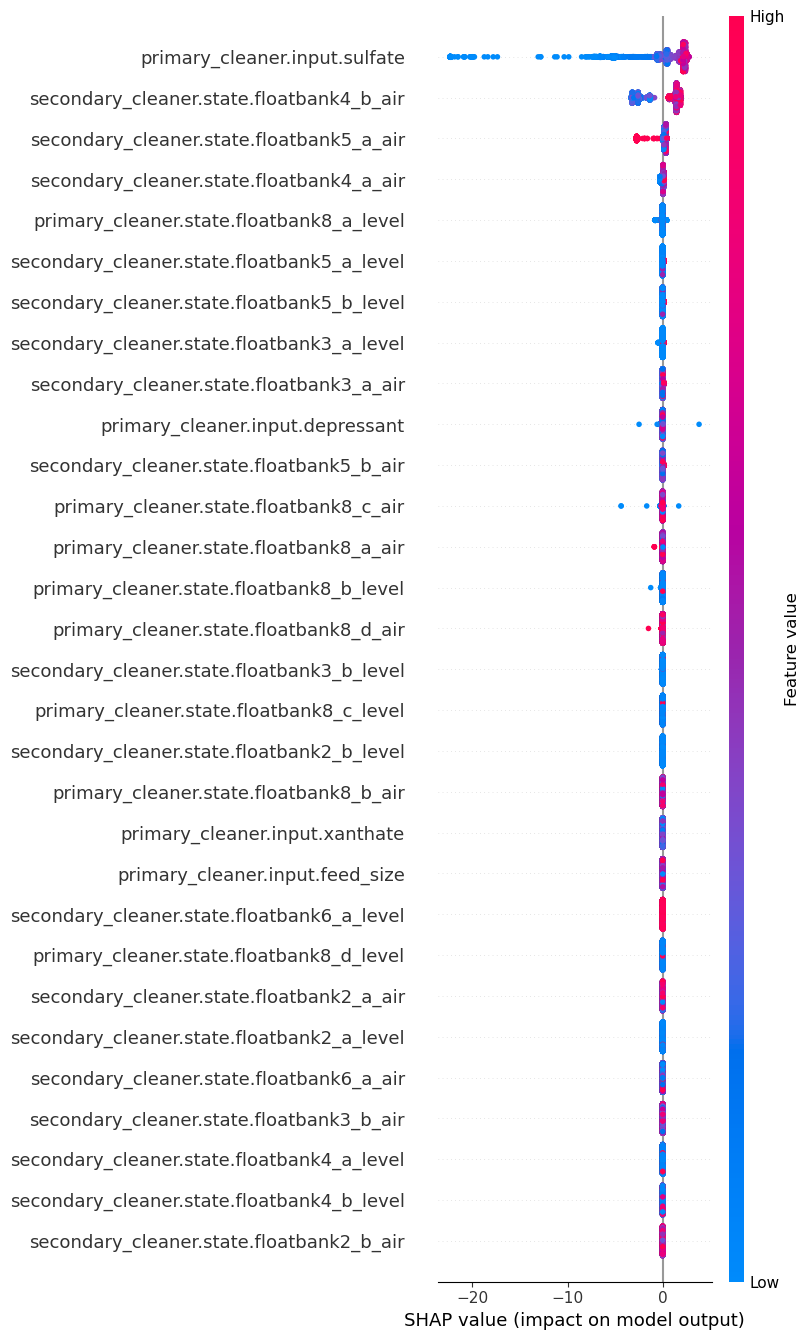

In [28]:
print('For flotation')
explainer_rougher = shap.TreeExplainer(best_model_rougher)
shap_values_rougher = explainer_rougher.shap_values(rougher_features_test)
shap.summary_plot(shap_values_rougher, rougher_features_test, max_display=60)

print('\n')
print('For the final stage')
explainer_final = shap.TreeExplainer(best_model_final)
shap_values_final = explainer_final.shap_values(final_features_test)
shap.summary_plot(shap_values_final, final_features_test, max_display=60)

#### Conclusions
Better results for both stages were shown by the random forest models obtained values for the test sample:  
sMAPE for flotation = 5.3 (on the training sample 12.6)  
sMAPE for final stage = 8.2 (on training sample 10.6)  
final_sMAPE = 7.5 (on training sample 11.1)  
It is interesting to note that most parameters have almost no effect on the predictions for the final stage, only the amount of sulfate is of great importance. While for flotation, many parameters have an essential influence on the result.

#### Dummy model

In [29]:
def dummy_predictions(features, targets, name):
    dummy_regr = DummyRegressor(strategy="mean")
    dummy_regr.fit(features, targets)
    dummy_predictions = dummy_regr.predict(features)
    dummy_sMAPE = sMAPE(targets, dummy_predictions)
    print(f'sMAPE for {name} with dummy model: {dummy_sMAPE}')
    return dummy_sMAPE

dummy_smape_rougher = dummy_predictions(rougher_features_test, rougher_target_test, 'flotation')
dummy_smape_final = dummy_predictions(final_features_test, final_target_test, 'final stage')
print('final_dummy_sMAPE for test data:', final_sMAPE(dummy_smape_rougher, dummy_smape_final))

sMAPE for flotation with dummy model: 5.896798901317004
sMAPE for final stage with dummy model: 9.133313373909662
final_dummy_sMAPE for test data: 8.324184755761497


It turns out that the dummy model also does an excellent job of predicting the target...

## Conclusions
### Data preparation
In general, the received data is in a good enough shape, the number of omissions is small.  
When cooperating with this company in the future, it is recommended to request initial data and instructions, and ask them not to split datasets without documentation, so that we do not have to deal with it later.  
The gaps were filled with the values closest in time.  
Parameters used for model training were normalized.  
The correctness of calculations was checked.
It turned out that train and test datasets are completely taken from a common dataset, while separated by time:  
train from 2016-01-15 to 2017-12-09 13:59, test from 2017-12-09 14:00 to 2018-08-18.

### Data Analysis
The **concentration of metals** at different stages of the processes was studied and it was shown that:  
Silver concentration in the mixture increases before the second purification, and decreases sharply in the final stage.
Flotation enriches the mixture with gold, the concentration, however, falls after the first purification and increases significantly only at the final stage.  
Flotation, as well as the second and final stages, enriches the mixture with lead.  
In this case, the concentration of all metals increases after flotation, but decreases after cleaning and a strong increase is noticeable only after the final stage.  

**Analysis of data from time**
The particle distribution was examined and shown to be general for the test and training samples.    
This is characteristic of both the particle size before flotation and before the first cleaning.  
Analysis of the additional parameters from time also showed that the data for the test and training samples are not significantly different.

### Training the model
**On the training sample**  
Additional data preprocessing was performed, and a function was written to calculate sMAPE and final sMAPE.  
Linear regression, decision tree, and random forest models were trained on the training sample using cross-validation.  
The random forest model performed best for both stages, although the linear regression and the solver tree model also gave close results.    
It is interesting to note that adding features about the flotation process to the model training for the final stage leads to a deterioration in the predictive power of the model. The best value of final_sMAPE on the training sample = .

**Test sample**  
The trained models showed the following results on the test sample:  
sMAPE for flotation = 5.3  
sMAPE for final stage = 8.2  
final_sMAPE = 7.5  
The better predictive power of the model on the test sample may be due to the fact that the data are more homogeneous for later records.